In [1]:
!pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import pickle
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [3]:
df = pd.read_csv('tourist_reviews.csv')
df

,id,datetime,location,text,rating,accessibility,facility,activity
0,47d0cdd937754bd6b860f89b2bab1dbb,2022-05-15 11:58:43,Curug Malela,Akses jalannya waktu itu masih sulit di jangka...,4,negative,neutral,neutral
1,4804acd6c05e4f89b098e2ca35019419,2022-08-15 11:58:43,Curug Malela,"Perjalanan yg bnr"" bikin Syahduu ,, dr Tempat ...",5,neutral,neutral,positive
2,3eae265bf32a45eca31765a4145bc030,2022-03-15 11:58:43,Curug Malela,"Minggu 13 februari 2022 ,\n\ngas santai pakai ...",5,positive,negative,positive
3,61037dbdb7b14045be49d4494e95cf05,2022-05-15 11:58:44,Curug Malela,7 mei 2022\nTouring bari mudik\nMntap perjalan...,5,positive,neutral,positive
4,a2c9e817e2b949c6880f971f43a11d2f,2022-08-15 11:58:44,Curug Malela,Perjalanan touring motor dari bekasi melewati ...,5,neutral,neutral,positive
...,...,...,...,...,...,...,...,...
11615,3246f6afdbd14fcabf656fdab909c761,2019-02-23 18:23:29,Terminal Wisata Grafika Cikole,Hanya mencoba sarapan dan offroad pakai land r...,4,neutral,negative,positive
11616,119428a78d9e4733a0d336ce2d7dd36e,2019-02-23 18:23:29,Terminal Wisata Grafika Cikole,"Pngnnya ksni petik strawberry tpi lgi g panen,...",4,neutral,neutral,neutral
11617,48f44c8866fa41138954b62b85395aba,2019-02-23 18:23:29,Terminal Wisata Grafika Cikole,Ksini cuma main aja dan lihat lihat. Suasanany...,4,neutral,neutral,positive
11618,81262ca72bd14de4948ba1e8f2052f3d,2022-12-23 18:23:29,Terminal Wisata Grafika Cikole,Luar biasa mantap makan prasmanan ny murah,5,neutral,positive,neutral


In [4]:
df = df.copy()

In [5]:
df.shape

(11620, 8)

## Cleaning Data

In [6]:
df = df.drop_duplicates("text")
df.shape

(11620, 8)

In [7]:
df = df.dropna()
df.isnull().sum()

id               0
datetime         0
location         0
text             0
rating           0
accessibility    0
facility         0
activity         0
dtype: int64

In [9]:
import re

In [10]:
def clean_text(text):
    text = re.sub(r"@[a-zA-Z0-9_]+", "", text) # hapus mention
    text = re.sub(r"#\w+", "", text) # hapus hashtag
    text = re.sub(r"https?://\S+", "", text) # hapus url
    text = re.sub(r"[^a-zA-Z0-9 ]", "", text) # hapus char selain alphanumeric
    text = re.sub(r"\s+", " ", text).strip() # hapus yg lebih dari 1 spasi

    return text

df["text"] = df["text"].apply(clean_text)

In [11]:
df["text"] = df["text"].str.lower()

In [12]:
df

,id,datetime,location,text,rating,accessibility,facility,activity
0,47d0cdd937754bd6b860f89b2bab1dbb,2022-05-15 11:58:43,Curug Malela,akses jalannya waktu itu masih sulit di jangka...,4,negative,neutral,neutral
1,4804acd6c05e4f89b098e2ca35019419,2022-08-15 11:58:43,Curug Malela,perjalanan yg bnr bikin syahduu dr tempat park...,5,neutral,neutral,positive
2,3eae265bf32a45eca31765a4145bc030,2022-03-15 11:58:43,Curug Malela,minggu 13 februari 2022 gas santai pakai motor...,5,positive,negative,positive
3,61037dbdb7b14045be49d4494e95cf05,2022-05-15 11:58:44,Curug Malela,7 mei 2022touring bari mudikmntap perjalanan s...,5,positive,neutral,positive
4,a2c9e817e2b949c6880f971f43a11d2f,2022-08-15 11:58:44,Curug Malela,perjalanan touring motor dari bekasi melewati ...,5,neutral,neutral,positive
...,...,...,...,...,...,...,...,...
11615,3246f6afdbd14fcabf656fdab909c761,2019-02-23 18:23:29,Terminal Wisata Grafika Cikole,hanya mencoba sarapan dan offroad pakai land r...,4,neutral,negative,positive
11616,119428a78d9e4733a0d336ce2d7dd36e,2019-02-23 18:23:29,Terminal Wisata Grafika Cikole,pngnnya ksni petik strawberry tpi lgi g panen ...,4,neutral,neutral,neutral
11617,48f44c8866fa41138954b62b85395aba,2019-02-23 18:23:29,Terminal Wisata Grafika Cikole,ksini cuma main aja dan lihat lihat suasananya...,4,neutral,neutral,positive
11618,81262ca72bd14de4948ba1e8f2052f3d,2022-12-23 18:23:29,Terminal Wisata Grafika Cikole,luar biasa mantap makan prasmanan ny murah,5,neutral,positive,neutral


## Preprocessing

### 1. Text Normalization

In [13]:
df_norm = df["text"]
df_norm

0        akses jalannya waktu itu masih sulit di jangka...
1        perjalanan yg bnr bikin syahduu dr tempat park...
2        minggu 13 februari 2022 gas santai pakai motor...
3        7 mei 2022touring bari mudikmntap perjalanan s...
4        perjalanan touring motor dari bekasi melewati ...
                               ...                        
11615    hanya mencoba sarapan dan offroad pakai land r...
11616    pngnnya ksni petik strawberry tpi lgi g panen ...
11617    ksini cuma main aja dan lihat lihat suasananya...
11618           luar biasa mantap makan prasmanan ny murah
11619               tempat dan suasananya sejuk bangeeettt
Name: text, Length: 11620, dtype: object

In [14]:
norm = {
    # row 1-2324
    "&" : " dan ",
    "/" : " atau ",
    "%" : " persen ",
        " menuji " : " menuju ",
    " bnr " : " benar ",
    " dr " : " dari ",
    " lelahh " : " lelah ",
    " disasarin " : " tersasar ",
    " sampe " : " sampai ",
    " tapi " : " tetapi ",
    " yg ": " yang ",
    " blom ": " belum ",
    " ati2 ": " hati-hati ",
    " tengah2 ": " tengah ",
    " aja " : " saja ",
    " 12rb " : " 12 ribu rupiah ",
    " 5rb " : " 5 ribu rupiah ",
    " 20rb " : " 20 ribu rupiah ",
    " gpp " : " tidak masalah ",
    " disana " : " di sana ",
    " trek " : " track ",
    " kudu " : " harus ",
    " sepi2 " : " sepi ",
    " amat " : " sekali ",
    " lg " : " sedang ",
    " bapa2 " : " bapak bapak ",
    " lapin " : " mengelap ",
    " sasapu " : " menyapu ",
    " baru2 " : " akhir akhir ",
    " pisan " : " banget ",
    " jatoh " : " jatuh ",
    " bapak2 " : " bapak bapak ",
    " 35rb " : " 35 ribu rupiah ",
    " 30rb " : " 30 ribu rupiah ",
    " treknya " : " track nya ",
    " gan " : " teman ",
    " jdi " : " menjadi ",
    " 50rb " : " 50 ribu rupiah ",
    " rejeki " : " rezeki ",
    " bangett " : " sekali ",
    " walopun " : " walaupun ",
    " btw " : " by the way ",
    " mntap " : " keren ",
    " nyampe " : " sampai ",
    " jln " : " jalan ",
    " lnjut " : " lanjut ",
    " kebawah " : " ke bawah ",
    " saung2 " : " saung ",
    " lagiii " : " lagi ",
    " dateng " : " datang ",
    " utk " : " untuk ",
    " org " : " orang ",
    " begituh " : " seperti itu ",
    " bangetttt " : " sekali ",
    " kec " : " kecamatan ",
    " kab " : " kabupaten ",
    " kebon " : " kebun ",
    " siap2 " : " siap-siap ",
    " dengab " : " dengan ",
    " bages " : " bagus ",
    " htm " : " harga tiket masuk ",
    " tak " : " tidak ",
    " unutk " : " untuk ",
    " ojek " : " ojek ",
    " dg " : " dengan ",
    " kawula " : " orang ",
    " hoby " : " hobi ",
    " aga " : " agak ",
    " 5rb " : " 5 ribu rupiah ",
    " keresek " : " kresek ",
    " mamang " : " bapak ",
    " 50rb " : " 50 ribu rupiah ",
    " sampek " : " sampai ",
    " hati2 " : " hati-hati ",
    " pas " : " waktu ",
    " kta " : " kota ",
    " trekking " : " tracking ",
    " klo " : " jika ",
    " plosok " : " pelosok ",
    " lbih " : " lebih ",
    " sia2 " : " sia-sia ",
    " abis " : " banget ",
    " ksini " : " ke tempat ini ",
    " ga " : " tidak ",
    " lbih " : " lebih ",
    " ksana " : " ke tempat itu ",
    " th " : " tahun ",
    " jlan " : " jalan ",
    " sayangny " : " sayangnya ",
    " jm " : " jam ",
    " krna " : " karena ",
    " ttp " : " tetap ",
    " kt " : " kata ",
    " smpe " : " sampai ",
    " sdh " : " sudah ",
    " bbrp " : " beberapa ",
    " pk " : " menggunakan ",
    " qu " : " aku ",
    " aqu " : " aku ",
    " indahhh " : " indah ",
    " sejukkk " : " sejuk ",
    " pisan " : " sekali ",
    " curugn " : " air terjun ",
    " tdr " : " tidak ",
    " eajib " : " wajib ",
    " ojeg " : " ojek ",
    " tkp " : " tempat ",
    " cape " : " capek ",
    " jgn " : " jangan ",
    " bener2 " : " benar benar ",
    " males " : " malas ",
    " kelokasi " : " ke lokasi ",
    " ko " : " kok ",
    " gk " : " tidak ",
    "selfi " : " selfie ",
    " sebelom " : " sebelum ",
    " gaes " : " guys ",
    " naek " : " naik ",
    " renovasi " : " renovasi ",
    " bngt " : " banget ",
    " sampah2 " : " sampah-sampah ",
    " tuk " : " untuk ",
    " kalo " : " jika ",
    " tak " : " tidak ",
    " mudahan " : " semoga ",
    " dpt " : " dapat ",
    " syh " : " saya ",
    " ditmpt " : " di tempat ",
    " cma " : " hanya ",
    " mnju " : " menuju ",
    " rekomend " : " rekomen ",
    " tdk " : " tidak ",
    " dwh " : " deh ",
    " gak " : " tidak ",
    " pake " : " pakai ",
    " krn " : " karena ",
    " ny " : " nya ",
    " yg " : " yang ",
    " bgitu " : " sangat ",
    " pp " : " pulang pergi ",
    " skitar " : " sekitar ",
    "mnt " : " menit ",
    " taun " : " tahun ",
    " benar2 " : " benar-benar ",
    " extta " : " extra ",
    " byk " : " banyak ",
    " lg " : " lagi ",
    " hrg " : " harga ",
    " jauhhhhhh " : " jauh ",
    " bajetnya " : " budget nya ",
    " kyanya " : " sepertinya ",
    " pbjek " : " objek ",
    " wista " : " wisata ",
    " gaberbau " : " tidak berbau ",
    " nich " : " nih ",
    " pisik " : " fisik ",
    " asama " : " asma ",
    " oksigan " : " oksigen ",
    " d " : " di ",
    " dispar " : " dinas pariwisata ",
    " perluditingkatkan " : " perlu ditingkatkan lagi ",
    " moga " : " semoga ",
    " g " : " tidak ",
    " sesui " : " sesuai ",
    " shre " : " share ",
    " krng " : " kurang ",
    " setelh " : " setelah ",
    " pround " : " proud ",
    " jg " : " juga ",
    " ut " : " it ",
    " tmpat " : " tempat ",
    " ksna " : " ke tempat itu ",
    " engak " : " tidak ",
    " dlm " : " dalam ",
    " kerenn " : " keren ",
    " penbenahan " : " pembenahan ",
    " sefti " : "safety ",
    " bngt " : " banget ",
    " gpppp " : " tidak masalah",
    " ujan " : " hujan ",
    " banyakkk " : " banyak ",
    " bangettt " : " sekali ",
    " org " : " orang ",
    " trus " : " lalu ",
    " thr " : " tunjangan hari raya ",
    " gamau " : " tidak mau ",
    " disitulah " : " di tempat itu ",
    " me gunjungi " : " mengunjungi ",
    " 25menit " : " 25 menit ",
    " ckup " : " cukup ",
    " n " : " dan ",
    " 15k " : " 15 ribu rupiah ",
    " 2k " : " 2 ribu rupiah ",
    " meski " : " meskipun ",
    " tp " : " tetapi ",
    " 2km " : " 2 kilometer ",
    " 30menitan " : " sekitar 30 menit ",
    " karna " : " karena ",
    " ojol " : " ojek ",
    " mcknya " : " mandi cuci kakus",
    " kesini " : " ke tempat ini ",
    " fikiran " : " pikiran ",
    " kata2 " : " kata kata ",
    " mengiyahkan " : " mengiyakan ",
    " aje " : " saja ",
    " nyesel " : " menyesal ",
    " sy " : " saya ",
    " joss " : " keren ",
    " ciri2nya " : " ciri cirinya ",
    " trimakasih " : " terima kasih ",
    " bis " : " bus ",
    " tsb " : " tersebut ",
    " 10ribu " : " 10 ribu rupiah ",
    " aor " : " air ",
    " skrg " : " sekarang ",
    " mangtab " : " keren ",
    " anak2 " : " anak anak ",
    " bru " : " baru ",
    " nympe " : " sampai ",
    " tpi " : " tetapi ",
    " sna " : " sana ",
    " akn " : " akan ",
    " wrung " : " warung ",
    " keci " : " kecil ",
    " klu " : " jika ",
    " musola " : " mushola ",
    " dkt " : " dekat ",
    " treking " : " tracking",
    " cman " : " hanya ",
    " 10rb " : " 10 ribu rupiah ",
    " 25rb " : " 25 ribu rupiah ",
    " bagusss " : " bagus ",
    " luass " : " luas ",
    " bangett " : " banget ",
    " pagipagi " : " pagi ",
    " lgi " : " lagi ",
    " b8sa " : " bisa ",
    " bgt " : " banget ",
    " 15rb " : " 15 ribu rupiah ",
    " kesana " : " ke tempat itu ",
    " trecking " : " tracking ",
    " lypa " : " lupa ",
    " pkonya " : " pokoknya ",
    " blm " : " belum ",
    " 2x " : " dua kali ",
    " tmpt " : " tempat ",
    " mh " : " ",
    " berhari2 " : " berhari hari ",
    " tetep " : " tetap ",
    " pipa2 " : " pipa pipa ",
    " sdikit " : " sedikit ",
    " cm " : " hanya ",
    " mushala " : " mushola ",
    " didekat " : " di dekat ",
    " didaerah " : " di daerah ",
    " di wajah " : " wajah ",
    " mentok " : " buntu ",
    " 5mnt " : " 5 menit ",
    " ksitunya " : " ke tempat itu ",
    " kerenz " : " keren ",
    " smoga " : " semoga ",
    " cmn " : " hanya ",
    " terujun " : " terjun ",
    " disini " : " di sini ",
    " 10k " : " 10 ribu rupiah ",
    " dilokasi " : " di lokasi ",
    " duduk2 " : " duduk duduk ",
    " karcis " : " tiket ",
    " sm " : " dengan ",
    " menyeberang " : " menyebrang ",
    " 25000 " : " 25 ribu rupiah ",
    " rp15000orang " : " 15 ribu rupiah per orang ",
    " pas " : " ketika ",
    " 10menit " : " 10 menit ",
    " segar " : " segar ",
    " ntapslah " : " keren ",
    " pemandanganny " : " pemandangannya ",
    " dll " : " dan lain lain ",
    " kereen " : " keren ",
    " dinginn " : " dingin ",
    " mobi " : " mobil ",
    " ika " : " jika ",
    " hik8ng " : " hiking ",
    " enakeuuuunn " : " enak ",
    " hnya " : " hanya ",
    " cuz " : " karena ",
    " di kunjungi " : " dikunjungi ",
    " kepenatan " : " rasa capek ",
    " keatas " : " ke atas",
    " berresiko " : " beresiko ",
    " msh " : " masih ",
    " mkn " : " makan ",
    " sprt " : " seperti ",
    " jd " : " sehingga ",
    " bw " : " bawa ",
    " maknyos " : " keren ",
    " penat " : " capek ",
    " na " : " nya ",
    " aga " : " sedikit ",
    " dtg " : " datang ",
    " aerny " : " airnya ",
    " ngapa2in " : " berkegiatan ",
    " gabosen2 " : " tidak pernah bosan ",
    " dirumah " : " di rumah ",
    " sehari2 " : " sehari hari ",
    " daach " : " sekali ",
    " eek " : " tai ",
    " cemal cemil " : " makan ",
    " ny " : " nya ",
    " nyh " : " nya ",
    " seger " : " segar ",
    " diitung " : " dihitung hitung ",
    " prgnya " : " pulangnya ",
    " gt " : " sih ",
    " mantep " : " keren ",
    " 22rb " : " 22 ribu rupiah ",
    " wc " : " kamar mandi ",
    " jauuuh " : " jauh ",
    " trus " : " lalu ",
    " mah " :  " sih ",
    " nyimpen " : " menyimpan ",
    " 10000 " : " 10 ribu rupiah ",
    " siap2 " : " siap siap ",
    " kemping " : " camping ",
    " famili " : " family ",
    " dengan " : " dengan ",
    " bnyk " : " banyak ",
    " fasilitas2 " : " fasilitas fasilitas ",
    "haiking " : " hiking",
    " org " : " orang ",
    " menikamati " : " menikmati ",
    " ht2 " : " hati hati ",
    " ke hati2an " : " kehati hatian ",
    " ataw " : " atau ",
    " anget " : " hangat ",
    " rapih " : " rapi ",
    " berbeda2 " : " berbeda beda ",
    " kekolam " : " ke kolam ",
    " diarea " : " di area ",
    " barang2 " : " barang barang ",
    " ngekem " : " camping ",
    " gaes " : " teman ",
    " sweeeejuk " : " sejuk ",
    " deket " : " dekat ",
    " dgn " : " dengan ",
    " adem " : " sejuk ",
    " ccok " : " cocok ",
    " jlan2 " : " jalan jalan ",
    " skedar " : " sekedar ",
    " melihat2 " : " melihat lihat",
    " monggo " : " silahkan ",
    " orng " : " orang ",
    " 2rb " : " 2 ribu rupiah ",
    " dipake " : " dipakai ",
    " di sayangkan " : " disayangkan ",
    " di pelihara " : " dipelihara",
    " brooohhh " : " teman ",
    " goweser " : " naik sepeda ",
    " cyrug " : " curug ",
    " seneng " : " senang ",
    " but " : " tetapi ",
    " gw " : " aku ",
    " di palakin " : " ditagih ",
    " di ambil " : " diambil ",
    " ato " : " atau ",
    " mantuulll " : " keren ",
    " vuew " : " view ",
    " geng " : " teman ",
    " shokat " : " sholat ",
    " terjunnyankerwn " : " terjunnya keren ",
    " euy " : " ",
    " original " : " natural ",
    " pedemi " : " pandemi ",
    " rame " : " ramai ",
    " di injak " : " diinjak ",
    " bdung " : " bandung ",
    " sgt " : " sangat ",
    " holiday " : " liburan ",
    " ad " : " ada ",
    " jmbatan " : " jembatan ",
    " ngeguide " : " memandu ",
    " warlok " : " warga lokal ",
    " bolong2 " : " berlubang ",
    " bnyak " : " banyak ",
    " sngat " : " sangat ",
    " ademmm " : " sejuk ",
    " termantep " : " paling keren ",
    " databg " : " datang ",
    " ayeum " : " ",
    " mantab " : " keren ",
    " jhga " : " juga ",
    " camp " : " camping ",
    " suasa " : " suasana ",
    " rada " : " cukup ",
    " stabdart " : " standar ",
    " nyaa " : " nya ",
    " kapok " : " rugi ",
    " disaat " : " ketika ",
    "  keu " : " ke ",
    " represing " : " refreshing ",
    " apalgi " : " apalagi ",
    " pendek2 " : " pendek pendek ",
    " fto " : " foto ",
    " juag " : " juga ",
    " hacking " : " hiking ",
    " unchh " : " ",
    " pmula " : " pemula ",
    " ksini " : " ke tempat ini",
    " serem2 " : " seram ",
    " hy " : " hanya ",
    " area2 " : " area area ",
    " berfoto2 " : " berfoto foto ",
    " diinjek " : " diinjak ",
    " gaka " : " saja ",
    " mantappp " : " keren ",
    " bos " :  " teman ",
    " trlalu " : " terlalu ",
    " mantafff " : " keren ",
    " murmer " : " murah sekali ",
    " pgn " : " ingin ",
    " gaterlalu " : " tidak terlalu ",
    " coy " : " teman ",
    " di renovasi " : " direnovasi ",
    " santay " : " santai ",
    " uhk " : " untuk ",
    " hikers " : " orang hiking ",
    " habiiiiiiiiis " : " habis ",
    "  10000 " : " 10 ribu rupiah ",
    " ñya " : " nya ",
    " kereñññn " : " keren ",
    " dàñ " : " dan ",
    " çàmping " : " camping ",
    " di caga " : " di caga ",
    " smua " : " semua ",
    " meninggoy " : " meninggal",
    " ngadem " : " nyari tempat sejuk ",
    " di permudah " : " dipermudah ",
    " kok " : " mengapa ",
    " lobang " : " lubang ",
    " di benahi " : " dibenahi ",
    " sok " : " sangat ",
    " happy " : " senang ",
    " kalou " : " jika ",
    " swjuk " : " sejuk ",
    " viewny " : " tempatnya ",
    " tot " : " teman ",
    " rda " : " agak ",
    " traciingnya " : " tracking ",
    " kamping " : " camping ",
    " garugi " : " tidak rugi ",
    " melibihi " : " melebihi ",
    " segeerr " : " segar ",
    " dingiin " : " dingin ",
    " historical " : " sejarah ",
    " maen " : " main ",
    " mantebb " : " keren ",
    " hyking " : " mendaki ",
    " tempatnyah " : " tempatnya ",
    " kereeenn " : " keren ",
    " nuangsa " : " nuansa ",
    " ngilangin " : " menghilangkan ",
    " foto2 " : " foto foto ",
    " sin " : " sih ",
    " out bond " : " outbound ",
    " biasaaaa " : " biasa ",
    " terjuannya " : " terjunnya ",
    " repressing " : " menyegarkan pikiran ",
    " pengen " : " ingin ",
    " menanyang " : " menyenangkan ",
    " freeeeeesh " : " sejuk ",
    " bagsu " : " bagus ",
    " pasilitas " : " fasilitas ",
    " bestie " : " teman ",
    " mantulll " : " keren ",
    " kudos " : " hormat ",
    " idr " : " rupiah ",
    " ala2 " : " sekedarnya ",
    " 16k " : " 16 ribu rupiah ",
    " groundnya " : " tempat ",
    " terdabeest " : " terbaik ",
    " adeeemmm " : " sejuk ",
    " gok " : " keren ",
    " kamp " : " camping ",
    " adeem " : " adem ",
    " jauhhhh " : " jauh ",
    " hrs " : " harus ",
    " bangat " : " banget ",
    " temoatnya " : " tempatnya ",
    " spy " : " supaya ",
    " pokona " : " pokoknya ",
    " gauide " : " pemandu ",
    " kempingpun " : " camping juga ",
    " braty " : " berat ",
    " mantul " : " keren ",
    " gn " : " gunung ",
    " motocros " : " motorcross ",
    " banayk " : " banyak ",
    " ora ono " : " tidak ada ",
    " mnuju " : " menuju ",
    " yaudh " : " ya sudah ",
    " bwt " : " untuk ",
    " gandeng " : " kesal ",
    " orkes " : " orchestra ",
    " seh " : " sih ",
    " 18k " : " 18 ribu rupiah ",
    " 8k " : " 8 ribu rupiah ",
    " 5k " : " 5 ribu rupiah ",
    " dingin2an " : " kedinginan ",
    " enaken " : " keren ",
    " ngopi2 " : " minum kopi ",
    " mw " : " mau ",
    " bangeeet " : " banget ",
    " lumyn " : " lumayan ",
    " skitr " : " sekitar ",
    " mengasikan " : " menyenangkan ",
    " mjd " : " menjadi ",
    " bapa " : " bapak ",
    " sumpek " : " sempit ",
    " atit " : " sakit ",
    " di jelajah " : " dijelajah ",
    " mantapppp " : " keren ",
    " mencekammmmm " : " mencekam ",
    " gaje " : " tidak jelas ",
    " rp8000 " : " 8 ribu rupiah ",
    " mantepppp " : " keren ",
    " jem " : " jam ",
    " dalamany " : " dalamnya ",
    " max " : " maksimal ",
    " bole " : " boleh ",
    " benas " : " bebas ",
    " poto " : " foto ",
    " standby " : " diam di sana ",
    " nuduk " : " nunduk ",
    " bwah " : " bawah ",
    " ud " : " sudah ",
    " yak " : " ya",
    " kuatir " : " khawatir ",
    " ai " : " Saya ",
    " 75k " : " 75 ribu rupiah ",
    " crewnya " : " staffnya ",
    " 27rb " : " 27 ribu rupiah ",
    " 45rb " : " 45 ribu rupiah ",
    " shutle " : " shuttle ",
    " 50rb " : " 50 ribu rupiah ",
    " krucils " : " anak anak ",
    " dkat " : " dekat ",
    " pd " : " semua ",
    " walopun " : " walaupun ",
    " skrg " : " sekarang ",
    " so " : " jadi ",
    " tram " : " bus ",
    " vocer " : " voucher ",
    " kayanya " : " sepertinya ",
    " yu " : " ayo ",
    " instagramebel " : " instagramable ",
    " sedkt " : " sedikit ",
    " tidsk " : " tidak ",
    " shg " : " sehingga ",
    " ygy " : " ya ",
    " sabi " : " bisa ",
    " gd " : " gedung ",
    " ngk " : " tidak ",
    " tlong " : " tolong ",
    " enaaak " : " enak ",
    " bwahnyq " : " bawahnya ",
    " mash " : " masih ",
    " cr " : " cari ",
    " t4 " : " tempat ",
    " gercep " : " gerak cepet ",
    " sktr " : " sekitar ",
    " sblm " : " sebelum ",
    " trlu " : " terlalu ",
    " pinter2 " : " pintar ",
    " letak2 " : " lokasi ",
    " embek " : " kambing ",
    " tercintah " : " tercinta ",
    " baguuss " : " bagus ",
    " soo " : " sangat ",
    " worted " : " untung ",
    " fannibjek " : " dan objek ",
    " gps " : " google maps ",
    " we visit here " : " kita berkunjung ke sini ",
    " hunting " : " ambil ",
    " fall " : " air terjun ",
    " litte " : " kecil ",
    " the " : " itu ",
    " map " : " maps ",
    " wonderfull " : " bagus ",
    " for " : " untuk ",
    " hunter " : " pencari ",
    " good " : " bagus ",
    " place " : " tempat ",
    " fit " : " bugar ",
    " recomended " : " direkomendasikan ",
    " overall " : " secara keseluruhan ",
    " is " : " itu ",
    " amazing " : " keren ",
    " love " : " cinta ",
    " view " : " pemandangan ",
    " must " : " harus ",
    " go " : " pergi ",
    " review " : " komentar ",
    " esthetic " : " keren ",
    " gasebo " : " gazebo ",
    " update " : " diperbarui ",
    " next " : " berikut ",
    " time " : " waktu ",
    " extreme " : " ekstrim ",
    " safety " : " keamanan ",
    " family " : " kealuarga ",
    " prewedding " : " prapernikahan ",
    " gathering " : " pertemuan ",
    " goodluck " : " semoga sukses ",
    " recommended " : " direkomendasikan ",
    " holiday " : " liburan ",
    " trip " : " petualangan jauh ",
    " my " : " milik saya ",
    " adventure " : " petualangan ",
    " spot " : " tempat ",
    " wara wiri " : " keliling ",
    " ticket " : " tiket ",
    " perorangnya " : " setiap orang ",
    " zoo " : " kebun binatang ",
    " ytk " : " untuk ",
    " lemontea " : " teh lemon ",
    " fav " : " favorit ",
    " lbh " : " lebih ",
    " keeerreeennnn " : " keren ",
    " hits " : " terkenal ",
    " tempatnyaa " : " tempatnya ",
    " yaa " : " ya ",
    " ngga " : " tidak ",
    " weekend " : " sabtu minggu ",
    " kmrn " : " kemarin ",
    " 50k " : " 50 ribu rupiah ",
    " 65k " : " 65 ribu rupiah ",
    " plgnya " : " pulangnya ",
    " gabisa " : " tidak bisa ",
    " gatau " : " tidak tahu ",
    " maybe " : " maybe ",
    " seempet " : " sempat ",
    " grimisss " : " gerimis ",
    " luass " : " luas ",
    " kmd " : " kemudian ",
    " emak2 " : " ibu ibu ",
    " nyawer " : " memberi uang ",
    " akang " : " bapak ",
    " including  " :  " termasuk ",
    " ramah2 " : " ramah ramah ",
    " banyaakkk " : " banyak ",
    " rameee " : " ramai ",
    " ampe " : " sampai ",
    " kl " : " jika ",
    " liar negri " : " luar negeri ",
    " seblm " : " sebelum ",
    " rb " : " ribu ",
    " bbrpa " : " beberapa ",
    " dpke " : " digunakan ",
    " wlwpun " : " walaupun ",
    " ttep " : " tetap ",
    " jga " : " juga ",
    " kesemua " : " ke semua ",
    " tmpt'a " : " tempatnya ",
    " helm'a " : " helmnya ",
    " mlah " : " malah ",
    " plng " : " pulang ",
    " gaaes " : " teman ",
    " kudu " : " harus ",
    " laper " : " lapar ",
    " aus " : " haus ",
    " gada " : " tidak ada ",
    " gtu " : " seperti itu ",
    " or " : " atau ",
    " dibawah " : " di bawah ",
    " baso-basoan " : " bakso ",
    " jenis2 " : " jenis jenis ",
    " discount " : " diskon ",
    " dalemnya " : " dalamnya ",
    " ramenya " : " ramainya ",
    " teteh " : " kakak ",
    " aa " : " kakak ",
    " kayak " : " seperti ",
    " kalai " : " jika ",
    " lampu2 " : " lampu lampu ",
    " okeeh " : " keren ",
    " pokonya " : " pokoknya ",
    " liberti " : " liberty ",
    " hapening " : " viral ",
    " pertiketnya " : " setiap tiketnya ",
    " cuman " : " hanya ",
    " selfinya " : "selfienya ",
    " dtng " : " datang ",
    " jmpt " : " jemput ",
    " swafoto " : " selfie ",
    " semuaaaaaa " : " semua ",
    " hoby " : " hobi ",
    " pricey " : " mahal ",
    " da " : " ",
    " owner " : " pemilik ",
    " dn " : " dan ",
    " disiang " : " di siang ",
    " pemandanga " : " pemandangan ",
    " ln " : " luar negeri ",
    " all " : " semua ",
    " package " : " paket ",
    " packed " : " paket ",
    " 90rb " : " 90 ribu rupiah ",
    " terll " : " terlalu ",
    " new " : " baru ",
    " destination " : " destinasi ",
    " at " : " di ",
    " sukak " : " suka ",
    " budget " : " uang ",
    " 50000 " : " 50 ribu rupiah ",
    " 65000 " : " 65 ribu rupiah ",
    " rekomended " : " direkomendasikan ",
    " t4nya " : " tempatnya ",
    " krg " : " kurang ",
    " ditiap " : " di setiap ",
    " ridak " : " tidak ",
    " selfy " : " selfie ",
    " bravo " : " hormat ",
    " tq " : " terima kasih ",
    " baik3 " : " baik ",
    " rama2 " : " ramah ",
    " luarr " : " luar ",
    " biasaaaa " : " biasa ",
    " walopun " : " walaupun ",
    " enjooyy " : " menyenangkan ",
    " recommendasi " : " rekomendasi ",
    " ala2 " : " ala ala ",
    " plus " : " ditambah ",
    " bermacan " : " bermacam ",
    " travle " : " travel ",
    " distamp " : " distempel ",
    " minus " : " kurang ",
    " kereeennnnnnn " : " keren ",
    " k e r e n " : " keren ",
    " di dukung " : " didukung ",
    " kedalam " : " ke dalam ",
    " photo " : " foto ",
    " nan " : " dan ",
    " terdapata " : " terdapat ",
    " mateng " : " matang ",
    " keceewa " : " kecewa ",
    " lembekw " : " lembek ",
    " sich " : " sih ",
    " pst " :  " pasti ",
    " 1,5 " : " satu setengah ",
    " banyaj " : " banyak ",
    " 1 x " : " satu kali ",
    " di buka " : " dibuka ",
    " jk " : " bercanda ",
    " bangetz " : " sekali ",
    " buanyak " : " banyak ",
    " dna " : " dan ",
    " pasport " : " passport ",
    " kenang kenangann " : " kenang kenangan ",
    " aktifitas " : " aktivitas ",
    " ituuuh " : " itu ",
    " nop " : " november ",
    " hewàn " : " hewan ",
    " dsbnya " : " dan sebagainya ",
    " fun " : " menyenangkan ",
    " pemandangn " : " pemandangan ",
    " cape2 " : " capek capek ",
    " bayr " : " bayar ",
    " istrht " : " istirahat ",
    " jaln " : " jalan ",
    " antriiiii " : " antre ",
    " b rampung " : " belum rampung ",
    " bis " : " bus ",
    " pakè " : " pakai ",
    " endah " : " indah ",
    " bgtu " : " seperti itu ",
    " wikend " : " sabtu minggu ",
    " potonya " : " fotonya ",
    " ngantri " : " ngantre ",
    " kesitu " : " ke tempat itu ",
    " puanasnyaaa " : " panasnya ",
    " selpi-selpi " : " selfie ",
    " berswa photo " : " selfie ",
    " dijmin " : " dijamin ",
    " gaskeun " : " ayo ",
    " enough " : " cukup ",
    " good " : " bagus ",
    " this " : " ini ",
    " kedatannya " : " kedatangannya ",
    " fobia " : " takut ",
    " nersih " : " bersih ",
    " jbatan " : " jembatan ",
    " phobia/takut " : " takut ",
    " pazalnya " : " karena ",
    " fulus " : " uang ",
    " trial " : " uji coba ",
    " opening " : " buka ",
    " beres " : " selesai ",
    " udh " : " sudah ",
    " riweh " : " ribet ",
    " full " : " semua ",
    " sun " : " matahari ",
    " diperbaiki " : " diperbaiki ",
    " u " : " untuk ",
    " medos " : " media sosial ",
    " photo2 " : " foto foto ",
    " update " : " memperbarui ",
    " qualitasnya " : " kualitasnya ",
    " vs " : " dibanding ",
    " cost " : " harga ",
    " too " : " sangat ",
    " high " : " mahal ",
    " k " : " ke ",
    " kaki'y " : " kakinya ",
    " mo " : " ingin ",
    " paspor2n " : " passport ",
    " paspor " : " passport ",
    " biasaaa " : " biasa ",
    " sa " : " dan ",
    " mantepppp " : " keren ",
    " live music " : " pertunjukan musik ",
    " tengah2 " : " tengah ",
    " uda " : " sudah ",
    " pokok nya " : " pokoknya ",
    " tempatny " : " tempatnya ",
    " untukbanak " : " untuk anak ",
    " ngak " : " tidak ",
    " bestie " : " teman ",
    "-" : " hingga ",
    " negri " : " negeri ",
    " klu " : " Jika ",
    " 50rbnya " : " 50 ribu rupiahnya ",
    " expektasi " : " ekspetasi ",
    " hrus " : " harus ",
    " seruuu " : " seru ",
    " loksi " : " lokasi ",
    " western " : " barat ",
    " chinese " : " china ",
    " bosa " : " bisa ",
    " 23k " : " 23 ribu rupiah ",
    " 30k " : " 30 ribu rupiah ",
    " terllu " : " terlalu ",
    " d tker " : " ditukar ",
    " mnuman " : " minuman ",
    " tnpa " : " tanpa ",
    
    " 20k " : " 20 ribu rupiah ",
    " htm " : " harga tiket masuk ",
    " 15rborang " : " 15 ribu rupiah per orang ",
    " 10rb " : " 10 ribu rupiah ",
    " org " : " orang ",
    " jg " : " juga ",
    " 15orang " : " 15 per orang ",
    " spot " : " titik ",
    " 45rb30 menit " : " 45 ribu rupiah per 30 menit ",
    " 45rb " : " 45 ribu rupiah ",
    " kynya " : " sepertinya ",
    " ga " : " tidak ",
    " dijagain " : " dijaga ",
    " td " : " tadi ",
    " aja " : " saja ",
    " pas " : " cocok ",
    " udahan " : " selesai ",
    " sampe " : " sampai ",
    " parkirin " : " memakirkan ",
    " udh " : " sudah ",
    " expert " : " mahir ",
    " gatau " : " tidak tahu ",
    " brp " : " berapa ",
    " soalnya " : " sebab ",
    " pake " : " pakai ",
    " 135rb " : " 13 ribu 500 ratus rupiah ",
    " banget " : " sekali ",
    " krn" : " karena ",
    " weekday " : " hari kerja ",
    " ngadem " : " menyejukkan diri ",
    " liat " : " lihat ",
    " 20rb " : " 20 ribu rupiah ",
    " 1spot " : " 1 titik ",
    " 15rb " : " 15 ribu rupiah ",
    " mushola " : " musala ",
    " main " : " bermain ",
    " food court " : " pujasera ",
    " belom " : " belum ",
    " adem " : " sejuk ",
    " recomended " : " rekomendasi ",
    " recomended " : " rekomendasi ",
    " recommended " : " rekomendasi ",
    " bgt " : " banget ",
    " kinyis " : " bersih ",
    " sampe " : " sampai ",
    " mushollanya " : " musalanya ",
    " 20rborg " : " 20 ribu rupiah per orang ",
    " 2th " : " lebih dari 2 tahun ",
    " udh " : " sudah ",
    " yaa " : " ya ",
    " weekend " : " akhir pekan ",
    " 5rb " : " 5 ribu rupiah ",
    " 10rb " : " 10 ribu rupiah ",
    " parkirannya " : " tempat parkirnya ",
    " instargrammable " : " dapat diunggah di instagram ",
    " bnyak " : " banyak ",
    " bgt " : " banget ",
    " stroller " : " kereta dorong bayi ",
    " jg " : " juga ",
    " yg " : " yang ",
    " msh " : " masih ",
    " pnya " : " punya ",
    " baby " : " bayi ",
    " toddler " : " balita ",
    " utk " : " untuk ",
    " tp " : " tapi ",
    " mayan " : " lumayan ",
    " 35rb " : " 35 ribu rupiah ",
    " dkt " : " dekat ",
    " bgt " : " banget ",
    " bs " : " bisa ",
    " ber3 " : " bertiga ",
    " ber4 " : " berempat ",
    " 85rb " : " 85 ribu rupiah ",
    " trus " : " terus ",
    " lg " : " lagi ",
    " bebekan " : " mainan bebek ",
    " 15rborg " : " 15 ribu rupiah per orang ",
    " bunganya " : " bunga bunganya ",
    " bersihh" : " bersih ",
    " b " : " biasa ",
    " posisi nya " : " posisinya ",
    " pas bgt " : " tepat sekali ",
    " pulak " : " pula ",
    " sholat " : " salat ",
    " bangunnya " : " pembangunannya ",
    " asalan " : " asal asalan ",
    " 300rb " : " 300 ribu rupiah ",
    " perorang " : " per orang",
    " krn " : " karena ",
    " bgtu " : " begitu ",
    " musolah " : " musala ",
    " lbh " : " lebih ",
    " mhn " : " mohon ",
    " smg " : " semoga ",
    " mksh " : " terima kasih ",
    " tak " : " tidak ",
    " dr " : " dari ",
    " plng " : " paling ",
    " mnt " : " menit ",
    " sanpe " : " sampai ",
    " ala2 " : " seperti ",
    " q " : " aku ",
    " msk " : " masuk ",
    " hr " : " hari ",
    " html " : " harga tiket masuk ",
    " sepedasepeda listril " : " sepeda listrik ",
    " 2025k " : " 20 sampai 25 ribu rupiah ",
    " kl " : " kalo ",
    " g " : " tidak ",
    " msk " : " masuk ",
    " bw " : " bawa ",
    " y " : " ya ",
    " food " : " makanan ",
    " varian " : " variasi ",
    " berliburberkumpul " : " berlibur atau berkumpul ",
    " i " : " saya ",
    " very " :  " sangat ",
    " happy " : " senang ",
    " bunga2 " : " bunga bunga ",
    " selfie " : " swafoto ",
    " track " : " jalur ",
    " dgn " : " dengan ",
    " stand2 " : " tempat jualan ",
    " rb " : " ribu rupiah ",
    " worthed " : " sepadan ",
    " 5rb " : " 5 ribu rupiah ",
    " spot2 " : " titik titik ",
    " ala " : " seperti ",
    " good " : " bagus ",
    " tmpt " : " tempat ",
    " renov " : " renovasi ",
    " photoshoot " : " pemotretan ",
    " Guide " : " pemandu ",
    " ngerti " : " mengerti ",
    " shooting " : " pengambilan gambar ",
    " frame " : " sudut pengambilan ",
    " nyesal " : " menyesal ",
    " bannding " : " dibanding ",
    " nga " : " tidak ",
    " trip " : " perjalanan ",
    " gak " : " tidak ",
    " semeriwing " : "sepoi sepoi ",
    " 15k " : " 15 ribu rupiah ",
    " 20k " : " 20 ribu rupiah ",
    " refreshing " : " menyegarkan diri ",
    " perorang " : " per orang ",
    " tetep " : " tetap ",
    " budget " : " anggaran ",
    " bikin " : " buat ",
    " nenangin " : " menenangkan ",
    " prewed " : " pranikah ",
    " jogging " : " joging ",
    " karna " : " karena ",
    " tp " : " tetapi ",
    " ujan " : " hujan ",
    " free " : " gratis ",
    " tuker " : " tukar ",
    " seger " : " segar ",
    " smua " : " semua ",
    " kalopun " : "kalaupun ",
    " jauuuhhh " : " jauh ",
    " anak2 " : " anak anak ",
    " rame " : " ramai ",
    " trus " : " terus ",
    " foto2 " : " foto foto ",
    " ibu2 " : " ibu ibu ",
    " gada " : " tidak ada ",
    " tau " : " tahu ",
    " selfi " : " swafoto ",
    " capek " : " lelah ",
    " byk " : " banyak ",
    " renovas " : " renovasi ",
    " benar2 " : " benar benar ",
    " view " : " pemandangan ",
    " best " : " terbaik ",
    " oya " : " iya ",
    " tsb " : " tersebut ",
    " gw " : " saya ",
    " stable " : " tempat berkuda ",
    " mandii " : " mandi ",
    " bwt " : " buat ",
    " foto2 " : " foto foto ",
    " mayan " : " lumayan ",
    " murmer " : " murah meriah ",
    " prewedding " : " pranikah ",
    " ilalang " : " alang alang ",
    " drink " : " minum ",
    " lmayan " : " lumayan ",
    " tmpat " : " tempat ",
    " mhal " : " mahal ",
    " bwat " : " buat ",
    " prmainan " : " permainan ",
    " outbond " : " kegiatan di luar ruangan ",
    " rapih " : " rapi ",
    " beca " : " becak ",
    " kalo " : " kalau ",
    " naek " : " naik ",
    " org " : " orang ",
    " mskpn " : " meskipun ",
    " thn " : " tahun ",
    " bngt " : " banget ",
    " thn " : " tahun ",
    " byr " : " bayar ",
    " sbntr " : " sebentar ",
    " prahub " : " perahu ",
    " spda " : " sepeda ",
    " trblng " : " terbilang ",
    " menungang " : " menunggang ",
    " dlm " : " dalam ",
    " 10k " : " 10 ribu rupiah ",
    " 15k " : " 15 ribu rupiah ",
    " 30k " : " 30 ribu rupiah ",
    " aamiin " : " amin ",
    " finishing " : " penyelesaian ",
    " bukit2nya " : " bukit bukitnya ",
    " hits " : " terkenal ",
    " expektasi " : " ekspektasi ",
    " sejuj " : " sejuk ",
    " geliat " : " aktivitas  ",
    " t4 " : " tempat ",
    " sekinya " : " sekiranya ",
    " sekitara " : " sekitaran ",
    " dll " : " dan lain lain ",
    " riding " : " berkuda ",
    " horse " : " kuda ",
    " fussion " : " paduan ",
    " nggak " : " tidak ",
    " top " : " terbaik ",
    " zoo " : " kebun binatang ",
    " jln " : " jalan ",
    " gk " : " tidak ",
    " hrg " : " harga ",
    " agak " : " sedikit ",
    " besar2 " : " besar besar ",
    " qta " : " kita ",
    " dalem " : " dalam ",
    " mantab " : " mantap ",
    " poto-poto " : " foto foto ",
    " gtau " :  " tidak tahu ",
    " rapih " : " rapi ",
    " yuk " : " ayo ",
    " dituker " : " ditukar ",
    " aj " : " saja ",
    " neduh " : " berteduh ",
    " hunting " : " berburu ",
    " macem " : " macam ",
    " karna " : " karena ",
    " mistis " : " mistik ",
    " klau " : " kalau ",
    " ng " : " tidak ",
    " snack " : " camilan ",
    " oke " : " baik ",
    " yqng " : " yang ",
    " mlepas " : " melepas ",
    " krena " : " karena ",
    " k " : " ke ",
    " sbaiknya " : " sebaiknya ",
    " selvi " : " swafoto ",
    " yaman " : " nyaman ",
    " d " : " di ",
    " to " : " untuk ",
    " apriciate " : " apresiasi ",
    " plus " : " dan ",
    " nice " : " bagus ",
    " bebenah " : " berbenah ",
    " swafhoto " : " swafoto ",
    " begtu " : " begitu ",
    " taun " : " tahun ",
    " baguss " : " bagus ",
    " rekomenin " : " rekomendasi ",
    " no " : " tidak ",
    " recoment "  : " rekomendasi ",
    " smua " : " mahal ",
    " pemrotrait " : " pemotret ",
    " blum " : " belum ",
    " respect " : " menghormati ",
    " org " : " orang ",
    " bad " : " buruk ",
    " seneng " :  " senang ",
    " cuma " : " cuma ",
    " lbh " : " lebih ",
    " nyantei " : " santai ",
    " sesek " : " sesak ",
    " dateng " : " datang ",
    " sdh " : " sudah ",
    " smakin " :  " semakin ",
    " masi " : " masih ",
    " hiruk " : " keramaian  ",
    " pikuk " : "keriuhan ",
    " sepedah "  : " sepada ",
    " rekomended " : " rekomendasi ",
    " 2x " : " 2 kali ",
    " unt " : " untuk ",
    " mantabz " : " mantap ",
    " baagguusss " : " bagus ",
    " tmp " : " tempat ",
    " ok " : " baik ",
    " bisaa " : " bisa ",
    " baxk " : " kembali ",
    " santeii " : " santai ",
    " relax " : " rileks ",
    " ornamen " : " ornamen ",
    " standart " : " standar ",
    " asiiiik " : " asyik ",
    " gils " : " gila ",
    " d " :  " di ",
    " but " : " tapi ",
    " bi " : " di ",
    " deket " : " dekat ",
    " sempet " : " sempat ",
    " bentar " :  " sebentar ",
    " photoable " : " dapat difoto ",
    " da " : " dan ",
    " bgus " : " bagus ",
    " klw " : " kalau ",
    " tmbah " : " tambah ",
    " brkesan " : " berkesan ",
    " cumqn " : " hanya ",
    " lg " : " lagi ",
    " komjnitas " : " komunitas ",
    " kqrna " : " karena ",
    " tampak " : " terlihat ",
    " ayem " : " tenang ",
    " pisan " : " sekali ",
    " seperto " : " seperti ",
    " tdk " : " tidak ",
    " joss " : " mantap ",
    " bgus " : " bagus ",
    " pricey " : " mahal ",
    " perlanyanan " : " pelayanan ",
    " caww " : " pergi ",
    " plesiran " : " pelesir ",
    " spy " : " supaya ",
    " klau " : " kalau ",
    " x-tra " : " ekstra ",
    " resto " : " restoran ",
    " btl " : " botol ",
    " kliatan " : " kelihatan ",
    " doank " : " saja ",
    " kelurga " : " keluarga ",
    " pengen " : " ingin ",
    " males " : " malas ",
    " happy " : " senang ",
    " puassss " : " puas ",
    " sekalii " : " sekali ",
    " kat " : " kata ",
    " untu " : " untuk ",
    " asik " : " asyik ",
    " sekedar " : " sekadar ",
    " view " : " pemandangan ",
    " ga " : " tidak ",
    " terlatak " : " terletak ",
    " menyamtap " : " menyantap ",
    " pakr " : " parkir ",
    " luamyan " : " lumayan ",
    " nasuk " : " masuk ",
    " rb " : " ribu ",
    " perorang " : " per orang",
    " gate " : " gerbang ",
    " eahana " : " wahana ",
    " guede " : " gede ",
    " jajanann " : " jajanan ",
    " didalam " : " di dalam ",
    " jd " : " jadi ",
    " yg " : " yang ",
    " bebek2kan " : " bebek bebekan ",
    " rban " : " ribu an ",
    " dikantin " : " di kantin",
    " udh " : " udah ",
    " sm " : " sama ",
    " emg " : " emang ",
    " kya " : " seperti ",
    " cs " : " layanan pelanggan ",
    " sunglasses " : " kacamatan ",
    " bwt " : " buat ",
    " dkt " : " dekat ",
    " 15k " : " 15 ribu ",
    " mngkin " : " mungkin ",
    " bangeg " : " banget ",
    " wefie " : "swafoto ",
    " cas " : " mengisi daya ",
    " d " : " di ",
    " karna " : " karena ",
    " gak " : " tidak ",
    " ntah " : " entah ",
    " sale " : " penjualan ",
    " trus " : " terus ",
    " gw " : " aku ",
    " ataw " : " atau ",
    " hepi " : " senang ",
    " take " : " mengambil ",
    " photos " : " foto ",
    " disetting " : " di atur ",
    " agt " : " agustus ",
    " tempatx " : " tempatnya ",
    " kmarin " : " kemarin ",
    " aaku " : " aku ",
    " ditamannya " : " di tamannya",
    " maenan " : " mainan ",
    " tp " : " tapi ",
    " anak2 " : " anak anak ",
    " lari2 " : " lari lari ",
    " udh " : " udah ",
    " lumanyan " : " lumayan ",
    " refresh " : " menyegarkan diri ",
    " tmptnya " : " tempatnya ",
    " pa " : " apa ",
    " lg " : " lagi ",
    " ajah " : " saja ",
    " gak " : " tidak ",
    " 2x " : " dua kali",
    " sy " : " saya ",
    " attidue " : " bersikap ",
    " blm " : " belum ",
    " tw " : " atau ",
    " kluarga " : " keluarga ",
    " dariluar " : " dari luar ",
    " sejukk " : " sejuk ",
    " bikin " : " buat ",
    " bangeettttt " : " banget ",
    " harii " : " hari ",
    " sejukk " : " sejuk ",
    " bnget " : " banget ",
    " kyak " : " seperti ",
    " kl " : " kalau ",
    " kesemsem " : " terpikat ",
    " sangatlahh " : " sangat ",
    " bazaar " : " bazar ",
    " equestriannya  " : " kegiatan berkuda ",
    " atilt " : " atlet ",
    " oranfg " : " orang ",
    " temoatnya " : " tempatnya ",
    " great " : " bagus ",
    " berpoto " : " berfoto ",
    " poto " : " foto ",
    " Kerennnn " :  " keren ",
    " nyantai " : " santai ",
    " vibe " : " suasana ",
    " pokonya " : " pokoknya ",
    " blom " : " belum ",
    " dng " : " dengan ",
    " represing " : " menyegarkan ",
    " kekuarga " : " keluarga ",
    " spt " : " seperti ",
    " enakeun " : " enak ",
    " timbel " : " nasi ",
    " 2jam " : " 2 jam ",
    " tlg " : " tolong ",
    " komplit " : " komplet ",
    " beres " : " selesai ",
    " bnyk  " : " banyak ",
    " jutek " : " jutek ",
    " beca " : "  becak ",
    " nanjak " : " naik ",
    " kira2 " : " kira kira ",
    " udh " : " sudah ",
    " n " : " dan ",
    " btebaran " : " bertebaran ",
    " trjangkau " : " terjangkau ",
    " k " : " ke ",
    " ad " : " ada ",
    " prlgkapannya " : " perlengkapannya ",
    " pnyewaannya " : " penyewaannya ",
    " enao ": " enak ",
    " perborg " : " per orang ",
    " jalnnya " : " jalannya ",
    " papping " : " berubin ",
    " Lumyan " : " lumayan ",
    " camping " : " kemah ",
    " da " : " ada ",
    " pengen " : " ingin ",
    " gakuat " : " tidak kuat ",
    " malem " : " malam ",
    " antriannya " : " antre ",
    " ngeden " : " mengejan ",
    " terjal " : " curam ",
    " musola " : " musala ",
    " solat " : " salat ",
    " wudhu " : " wudu ",
    " cape " : " lelah ",
    " naek " : " naik " ,
    " edan " : " gila ",
    " mengexplore " : " mengeksplorasi ",
    " kemping " : " kemah ",
    " brangkat " : " berangkat ",
    " kereen " : " keren ",
    " tetus " : " terus ",
    " bjat " : " buat ",
    " Kereen " : " keren ",
    " dsini " : " disini ",
    " cm " : " cuma ",
    " 10mnt " : " 10 menit ",
    " tampat " : " tempat ",
    " nyampe " : " sampai ",
    " dsni " : " disini ",
    " skdar " : " sekadar ",
    " ceriaaaa " : " ceria ",
    " nanjakk " : " naik ",
    " pohon2 " : " pohon pohon ",
    " ngantri " : " antre ",
    " bunker " : " bungker ",
    " walopun " : " walaupun ",
    " abishnya " : " habisnya ",
    " ngangenin " : " dirindukan ",
    " keukeuh " : " kukuh ",
    " pengen " : " ingin ",
    " kece " : " keren ",
    " unt " : " untuk ",
    " musholla " : " musala ",
    " bingits " :  " banget ",
    " explore " : " eksplorasi ",
    " next " : " selanjutnya ",
    " gowes " : " bersepeda ",
    " pisan " : " banget ", #2807
    " hanua " : " hanya",
    " tipis2 " : " tipis tipis ",
    " pulsng " : " pulang ",
    " mantaab " : " pulang ",
    " harung " : " harus ",
    " Kerennnnnnnnnnnnnn " : " keren ",
    " kemaren " : " kemarin ",
    " nyimpen " : " simpan ",
    " pemual " : " pemula ",
    " tracking " : " jalur ",
    " ato " : " atau ",
    " bener " : " benar ",
    " ujan " : " hujan ",
    " camp " : " kemah ",
    " healing " : " pemulihan ",
    " sudsh  " : " sudah ",
    " mo " : "  mau ",
    " suru " : " suruh ",
    " ngomel " : " mengomeli ",
    " tempet " : " tempat ",
    " sapa " : " siapa ",
    " ktm " : " kartu tiket masuk ",
    " kate " : " kata ",
    " mck " : " mandi cuci kakus ",
    " 16c" : " 16 celcius ",
    " jug " : " juga ",
    " friendly " : " ramah ",
    " terlove " : " tercinta ",
    " abis " : " habis ",
    " trayek " : " rute ",
    " baut " : "  buat ",
    " khwartir " : " khawatir ",
    " alammm " : " alam ",
    " orng " : " orang ",
    " pdhal " : " padahal ",
    " sma " : " sama ",
    " gimna " : " gimana ",
    " nerima " : " menerima ",
    " pdahal " : " padahal ",
    " beutaheun " : " dengan nyaman ",
    " ksh " : " kasih ",
    " fit " : " bugar ",
    " 30mnt " : " 30 menit ",
    " semilir " : " beringin ",
    " trekkingnya " : " pendakiannya ",
    " dipake " : " dipakai ",
    " lobng " : " lubang ",
    " musholah " : " musala ",
    " yng " : " yang ",
    " anter " : " hantar ",
    " berjalannaik " : " berjalan naik ",
    " pict " : " foto ",
    " 7pagi" : " pagi ",
    " nemenin " : " menemani  ",
    " beres " : " selesai ",
    " glamour " : " glamor ",
    " gn " : " gunung ",
    " tapiiii " : " tapi ",
    " juva " : "  juga ",
    " sblm " : " sebelum ",
    " biiasanya " : " biasanya ",
    " paforit " : " favorit ",
    " bareng " : "  bersama ",
    " jadian " : " jadikan ",
    " nyampah " : " mengotori ",
    " emang " : " memang ",
    " nyesel " : " menyesal ",
    " rm " : " rumah makan ",
    " hny " : " hanya ",
    " kearah " : " ke arah ",
    " bangeeet " : " banget ",
    " mantep " : " mantap ",
    " ajibbb " : " menakjubkan ",
    " duduk2 " : " duduk duduk",
    " arau " : " atau ",
    " dasyat " : " dahsyat ",
    " keramahnya " : " keramahannya ",
    " treking " : " pendakiannya ",
    " lowbadget " : " anggaran rendah ",
    " mushala " : " musala ",
    " ngecamp " : " berkemah ",
    " hujann " : " hujan ",
    " enjoy " : "  santai ",
    " keatasny " : " ke atasnya",
    " Rimantis " : "  romantis ",
    " smp " : " sampai ",
    " nyubuh " : " subuh ",
    " mantaaap " : " mantap ",
    " goweser " : " pengendara sepeda ",
    " Kereeenn " : " keren ",
    " apalgi " : "  apalagi ",
    " arealnya " : " areal ",
    " hawatir " : " khawatir ",
    " jln " : " jalan ",
    " kemcer " : " kemping ceria ",
    " mls " : " malas ",
    " dianter " : " dihantar ",
    " ce " : " perempuan ",
    " gasengaaja " : " tidak sengaja ",
    " jos " : " mantap ",
    " pinter " : " pintar ",
    " milih " : " pilih ",
    " muncak " : " mendaki ",
    " cepet " : " cepat ",
    " kran " : " keran ",
    " mantaaaaap " : " mantap ",
    " kasian " : " kasihan ",
    " antrian " : " antrean ",
    " laper " : " lapar ",
    " nanjaknya " : " menanjaknya ",
    " ninggalin " : " meninggalkan ",
    " dadakan " : " mendadak ",
    " 200rb " : " 200 ribu rupiah ",
    " susana " : " suasana ",
    " malah " : " malahan ",
    " set " : " setengah ",
    " mengecewalan " : " mengecewakan ",
    " beautiful " : " cantik ",
    " jga " : " juga ",
    " recomend " : " rekomendasi ",
    " munisnya " : " manisnya ",
    " tjakep " : " cantik ",
    " menennangkan " : " menenangkan ",
    " nginep " : " menginap ",
    " penat " : " lelah ",
    " rekomen " : " rekomendasi ",
    " 40menit" : " 40 menit ",
    " favourit " : " favorit ",
    " mnrt " : " menurut",
    " mai " :  " mau ",
    " dsni " : " disini ",
    " klo " : " kalau ",
    " kegunung " : " ke gunung ",
    " krg " : " kurang ",
    " kamping " : " ",
    " mlm " : " malam ",
    " Tanjqkannya " : " tanjakannya ",
    " trlalu " : " terlalu ",
    " cndrung " : " cenderung ",
    " pmula " : " pemula ",
    " gw " : " saya ",
    " ngelepas " : " melepas ",
    " atw " : " atau ",
    " nongkrong " : " kumpul ",
    " cocok " : " sesuai ",
    " ngopi " : " minum kopi ",
    " mushalla " : " musala ",
    " niis " : " sejuk ",
    " dlarang " : " dilarang ",
    " bwa " : " bawa ",
    " jauh2 " : " jauh jauh ",
    " nyantai " : " bersantai ",
    " dpt " : " dapat ",
    " asikk " : " asyik ",
    " dkt " : " dekat ",
    " disuguhin " : " menyuguhi ",
    " smazing " : " menakjubkan ",
    " negri " : " negeri ",
    " kupat " : " tipat ",
    " nancap " : " tancap ",
    " endahnya " : " indah ",
    " sbagian " : " sebagian ",
    " refreahing " : " menyegarkan ",
    " refres " : " menyegarkan ",
    " suadha " : " sudah ",
    " suguhken " : " disungguhkan ",
    " ajibbbb " : " menakjubkan",
    " pisannnnnnn " : " sekali ",
    " ngobrol " : " berbincang ",
    " bkin " : " buat ",
    " mmng " : " memang ",
    " ccok " : " cocok ",
    " kmpul " : " kumpul ",
    " breng " : " bareng ",
    " tmn " : " teman ",
    " mager " : " malas gerak ",
    " battt " : " banget ",
    " ngcamp " : " berkemah ",
    " campingannya " : " perkemahannya ",
    " Hatihati " : " hati hati ",
    " enggak " : " tidak ",
    " engga " : " tidak ",
    " bercamping " : " berkemah ",
    " tada " : " tidak ada ",
    " alaynya " : " berlebihan ",
    " teriak2 " : " teriak teriak ",
    " malem2 " : " malam malam ",
    " doang " : " saja ",
    " skarang " : " sekarang ",
    " Raos " : " rasa ",
    " lgh " : " lagi ",
    " antrian " : " antrean ",
    " mantaaaaaaap " : " mantap ",
    " view " : " pemandangan ",
    " sunrise " : " matahari terbit ",
    " sunset " : " matahari terbenam ",
    " Jossssssss " : " mantap ",
    " untuj " : " untuk ",
    " dn " : " dan ",
    " kluarga " : " keluarga ",
    " kekempingan " : " berkemah ",
    " nyantai2 " : " santai santai ",
    " riaa " : " ria ",
    " peraltan " : " peralatan ",
    " verkemah " : " berkemah ",
    " menwan " : " menawan ",
    " Segerrr " : " segar ",
    " cemping " : " berkemah ",
    " dapet " : " dapat ",
    " mantul " : " mantap ",
    " pesen " : " pesan ",
    " sumpeknya " : " sempit ",
    " gile " : " gila ",
    " bener " : " benar ",
    " affordable " : " terjangkau ",
    " shubuh " : " subuh ",
    " kpd " : " kepada ",
    " bkar " : " bakar ",
    " kebutugan " : " kebutuhan ",
    " sebenernya " : " sebenarnya ",
    " maen " : " main ",
    " dingim " : " dingin ",
    " mantaf " : " mantap ",
    " ads " : " ada ",
    " kmr " : " kamar ",
    " bosen " : " bosan ",
    " codok " : " cocok ",
    " bertakafur " : " bertafakur ",
    " beeneran " : " beneran ",
    " mantaps " : " mantap ",
    " makrab " : " malam keakraban ",
    " enaknbuat " : " enak buat ",
    " nyalain " : " dihidupkan ",
    " sna " : " sana ",
    " pdhal " : " padahal ",
    " hika " : " jika ",
    " aluas " : " seluas ",
    " hrus " : " harus ",
    " siaang " : " siang ",
    " ajh " : " saja ",
    " mrngisi " : " mengisi ",
    " merefreshkan " : " menyegarkan ",
    " faporit " : " favorit ",
    " overall " : " keseluruhan ",
    " kecapean " : " kelelahan ",
    " cociks " : " cocok",
    " musholah " : " musala ",
    " Mengesahkan " : " mengesankan ",
    " antriiiii " : " antre ",
    " wc ": " kloset ",
    " gokil " : " menakjubkan ",
    " ingen " : " ingin ",
    " gunug " : " gunung ",
    " kebelut " : " kebelet ",
    " beud " : " banget ",
    " saranmah " : " saran ",
    " sangay " : " sangat ",
    " indsh " : " indah " ,
    " mslam " : " malam ",
    " mengahabiskan " : " menghabiskan ",
    " memliki " : " memiliki ",
    " sepedahan " : " bersepeda ",
    " kamping " : " berkemah ",
    " vieewnya " : " pemandangan ",
    " overpriced " : " terlalu mahal ",
    " cwe " : " perempuan ",
    " Asiik " : " asyik ",
    " mengkoordinir " : " mengoordinasikan ",
    " terllu " : " terlalu ",
    " bgs " : " bagus ",
    " apapum " : " apapun ",
    " sahdu " : " syahdu ",
    " kudu " : " harus ",
    " mayar " : " bayar ",
    " rapet " : " rapat ",
    " bgtu " : " begitu ",
    " seruuuu " : " seru ",
    " indaaaaahhh " : " indah ",
    " lrbih " : " lebih ",
    " gmna " : " gimana ",
    " hp " : " ponsel ",
    " tempan " : " tempat ",
    " pokoknamah " : " pokoknya ",
    " gapernah " : " tidak pernah ",
    " mantafff " : " mantap ",
    " poko ": " pokok ",
    " reccom " : " rekomendasi ",
    " mending " : " lebih baik ",
    " dsn " : " disana ",
    " serem  " : " seram ",
    " eksotik " : " eksotis ",
    " adeum " : " adem ",
    " sejukkk " : " sejuk ",
    " mantab " : " mantap ",
    " baguss " : " bagus ",
    " nagua " : " mengagumkan ",
    " ush " : " sudah ",
    " camcer " : " kemah ceria ",
    " hatibkarena " : " hati karena ",
    " km " : " kilometer ",
    " mantaaapppp " : " mantap ",
    " bangt " : " banget ",
    " sekrang " : " sekarang ",
    " Asique " : " asyik ",
    " ngena " : " merasa ",
    " 1tekat " : " 1 tiket ",
    " Cukuup " : " cukup ",
    " diperbaikiii " : " diperbaiki ",
    " soe " : " sore",
    " yari " : " hari ",
    " recomnded " : " rekomendasi ",
    " jauuuuh " : " jauh ",
    " enakkeuuuun " : " enak ",
    " nagus " : " bagus ",
    " ninggalin " : " meninggalkan ",
    " nyamaaaan " : " nyaman ",
    " bangeet " : " banget ",
    " ramah2 " : " ramah ramah ",
    " mntap " : " mantap ",
    " ngeliat " : " melihat ",
    " fikiran " : " pikiran ",
    " kavling " : " kaveling ",
    " jan " : " jangan ",
    " eksplor " : " eksplorasi ",
    " ntaps " : " mantap ",
    " Mnatapp " : " mantap ",
    " syrategis " : " strategis ",
    " daki " : " didaki ",
    " dekeettt " : " dekat ",
    " terbaiiiikkkk " : " terbaik ",
    " kerenn " : " keren ",
    " juaraaa " : " juara ",
    " sekalih " : " sekali ",
    " negri " : " negeri ",
    " full " : " penuh ",
    " beud " : " banget ",
    " enakk " : " enak ",
    " panoraman " : " panorama ",
    " nyasar " : " tersesat ",
    " ngetes " : " menguji ",
    " ribet " : " rumit ",
    " anget " : " hangat ",
    " musolla " : " musala ",
    " jurig " : " jarang ",
    " kerreeeen " : " keren ",
    " ceriahhh " : " ceria ",
    " kalopun " : " kalaupun ",
    " bagussss " : " bagus ",
    " ekstrim " : " ekstrem ",
    " ngikutin " : " mengikuti ",
    " pengen " : " ingin ",
    " ditenggarai " : " diduga ",
    " jlan " : " jalan ",
    " cindramata " : " cendera mata ",
    " beteduh " : " berteduh ",
    " nyegerin " : " menyegarkan ",
    " jng " : " jangan ",
    " sng " : " sangat ",
    " bagussscocok " : " bagus cocok ",
    " aplg " : " apalagi ",
    " ft " : " foto ",
    " nyamperin " : " menghampiri ",
    " kunjinginya " : " dikunjungi ",
    " kresek " : " plastik ",
    " runcing2 " : " runcing runcing ",
    " baguuuus " : " bagus ",
    " sawung " : " saung ",
    " kpengin " : " ingin ",
    " temoat " : " tempat ",
    " ampuuunnn " : " ampun ",
    " baso " : " bakso ",
    " pungli " : " pungutan liar ",
    " gadimakan " : " tidak dimakan ",
    " sudh " : " sudah ",
    " bberpa " : " beberapa ",
    " local " : " lokal ",
    " yabg " : " yang ",
    " bangay " : " banget ",
    " indha " : " indah ",
    " kanna " : " kanan ",
    " puanas " : " panas ",
    " tenpatnya " : " tempatnya ",
    " dijanhkau " : " dijangkau ",
    " alamo " : " alami ",
    " dicopot " : " dilepas ",
    " bavus " : " bagus ",
    " dri " : " dari ",
    " siqng " : " siang ",
    " dijangakau " : " dijangkau ",
    " breng " : " bersama ",
    " kluarga " : " keluarga ",
    " guide " : " memandu ",
    " expert " : " ahli ",
    " amenities " : " fasilitas ",
    " seruuuuu " : " seru ",
    " kemarennya " : " kemarin ",
    " kereen " : " keren ",
    " hot " : " panas ",
    " tanahbjadi " : " tanah jadi ",
    " sajjah " : " saja ",
    " begiyu " : " begitu ",
    " karna " : " karena ",
    " muncuk " : " muncul ",
    " dtang " : " datang ",
    " jepretan " : " memotret ",
    " manora " : " panorama ",
    " bnyk " : " banyak ",
    " askes " : " akses ",
    " garden " : " taman ",
    " parahh " : " parah ",
    " fhoto " : " foto ",
    " xtrim " : " ekstrem ",
    " nyasar " : " tersesat ",
    " kaga " : " tidak ",
    " nampol " : " menampar ",
    " hsl " : " hasil ",
    " tsb " : " tersebut ",
    " sebrang " : " seberang ",
    " sdm " : " sumber daya manusia ",
    " menangtang " : " menantang ",
    " bèrolah " : " berolah ",
    " monyedddd " : " monyet ",
    " ngakak " : " tertawa ",
    " kereeeennnnnn " : " keren ",
    " naek " : " naik ",
    " amazinggggggg " : " menakjubkan ",
    " idup " : " hidup ",
    " merka " : "mereka ",
    " lamaaaaaa " : " lama ",
    " ketimbun " : " tertimbun ",
    " mreeka " : " mereka ",
    " stgh " : " setengah ",
    " nitip " : " titip ",
    " jaih " : " jauh ",
    " untukmau " : " untuk mau ",
    " paki " : " pakai ",
    " ngbrol2 " : " ngobrol ",
    " klw " : " kalau ",
    " trmpat " : " tempat ",
    " ulab " : " ulah ",
    " adeeem " : " sejuk ",
    " manjain " : " ",
    " tajem2 " : " tajam tajam ",
    " aga " : " lumayan ",
    " sperti " : " seperti ",
    " nyampe " : " sampai ",
    " nyamperin " : " menghampiri ",
    " mntneering " : " pendakian gunung ",
    " daaannnn " : " dan ",
    " kedaeraah  " : " ke daerah ",
    " nyeselll " : " menyesal ",
    " nakan " : " akan ",
    " buruan " : " cepat ",
    " sllu " : " selalu ",
    " krja " : " kerja ",
    " pengen " : " pingin ",
    " mantabb " : " mantap ",
    " cucok " : " cocok ",
    " simonyetna " : " monyetnya",
    " beesih " : " bersih ",
    " denger " : " dengar ",
    " make " : " memakai ",
    " indahhhh " : " indah ",
    " letaanknya " : " letaknya ",
    " artistic " : " artistik ",
    " mantuuul " : " mantap ",
    " well " : " baik ",
    " mencobaaa " : " mencoba ",
    " indaaah " : " indah ",
    " hawatir " : " khawatir ",
    " dipalakin " : " dipaksa ",
    " mantulll " : " mantap ",
    " fto " : " foto ",
    " rekomendt " : " rekomendasi ",
    " menangtang " : " menantang ",
    " kereeen " : " keren ",
    " jlanan " : " jalanan ",
    " nyobain " : " mencoba ",
    " aplg " : " apalagi ",
    " begtu " : " begitu ",
    " tenteng " : " membawa ",
    " terunch " : " tergemas ",
    " knangannya " : " kenangannya ",
    " minus " : " kurang ",
    " hrga " : " harga ",
    " jeblog " : " buruk ",
    " laper " : " lapar ",
    " ngg " : " tidak ",
    " perjlanan " : " perjalanan ",
    " bgus ": " bagus ",
    " byar " : " bayar ",
    " manjat " : " panjat ",
    " bwt " : " buat ",
    " neduh " : " berteduh ",
    " kreatifitas " : " kreativitas ",
    " gowes " : " bersepeda ",
    " mf " : " maaf ",
    " terfavorite " : " terfavorit ",
    " daitamah " : " ditambah ",
    " teurus " : " terurus ",
    " hoby " : " hobi ",
    " kereeen " : " keren ",
    " clasic " : " klasik ",
    " jaman " : " zaman ",
    " nyemot " : " monyet ",
    " pemandanfan " : " pemandangan ",
    " kereeeen " : " keren ",
    " fotogenic " : " fotogenik ",
    " sendal " : " sandal ",
    " asiiikkkk " : " asyik ",
    " exotic " : " eksotis ",
    " professional " : " profesional ",
    " management " : " manajemen ",
    " ancuuurrr " : " hancur ",
    " sepanjabg " : " sepanjang ",
    " apesnya " : " sial ",
    " bajetnya " : " anggaran ",
    " tooilet " : "  toilet ",
    " xtrime " : " ekstrem ",
    " vidionya " : " video ",
    " awesome " : " mengagumkan ",
    " kebnayakn " : " kebanyakan ",
    " diinapkan " : " ditempatkan ",
    " ati " : " hati ",
    " extra " : " ekstra ",
    " charge " : " dikenakan biaya ",
    " selvi " : " swafoto ",
    " fhot " : " foto ",
    " wedding " : " pernikahan ",
    " bemper " : " bumper ",
    " dpr " : " dapat ",
    " dsni " : " disini ",
    " ngademmmm " : " menyejukkan diri ",
    " klau " : " kalau ",
    " selfy " : " swafoto ",
    " fersin " : " menyegarkan ",
    " baguuussss " : " bagus ",
    " mending " : " lebih baik ",
    " berfariasi " : " bervariasi ",
    " prnh " : " pernah ",
    " ksni " : " kesini ",
    " stu " : " kesitu ",
    " tarip " : " tarif ",
    " buangged " : " banget ",
    " puanasss " : " panas ",
    " kerennn " : " keren ",
    " pokoe " : " pokoknya ",
    " apalg " : " apalagi ",
    " skitarannya " : " sekitarannya ",
    " bgini " : " begini ",
    " mobiil " : " mobil ",
    " bhsa " : " bahasa ",
    " sedep " : " sedap ",
    " mudah2an " : " mudah mudahan ",
    " ao " : " apa ",
    " mehong " : " mahal ",
    " trap " : " perangkap ",
    " cma " : " cuma ",
    " jalannan " : " jalanan ",
    " wkt " : " waktu ",
    " msknya " : " masuknya ",
    " gaush " : " tidak perlu ",
    " mknan " : " makanan ",
    " getokan " : " negosiasi ",
    " pengunujung " : " pengunjung ",
    " tmpatnya " : " tempatnya ",
    " laper " : " lapar ",
    " batu2ny " : " batu batunya ",
    " besttt " : " terbaik ",
    " nganterin " : " mengantarkan ",
    " berish " : " bersih ",
    " meres " : " menguras ",
    " soalnua " : " soalnya ",
    " love " : " suka ",
    " instagramable " : " dapat diunggah di instagram ",
    " goa " : " gua ",
    " idup " : " hidup ",
    " pmandangan ": " pemandangan ",
    " buruan " : " cepat ",
    " gaa " : " tidak ",
    " belom " : " belum ",
    " penambagan " : " penambangan ",
    " prmandangan " : " pemandangan ",
    " penerabfan " : " penerangan ",
    " tuk " : " untuk ",
    " aktifitas " : " aktivitas ",
    " panasss " : " panas ",
    " indahhhhhhhhhhhhh " : " indah ",
    " bagusssssssssss " : " bagus ",
    " murahh " : " murah ",
    " datengi " : " mendatangi ",
    " skrg " : " sekaran ",
    " mntn " : " mantan ",
    " akhirya " : " akhirnya ",
    " catchy " : " menarik ",
    " nyangka " : " sangka ",
    " bertanggunjawab " : " bertanggung jawab ",
    " trlalu " : " terlalu ",
    " kliatan " : " keliatan ",
    " jl " : " jalan ",
    " beresnya " : " selesai ",
    " beresin " : " selesaikan ",
    " angelnya " : " sudut pengambilan gambra ",
    " mantaap " : " mantap ",
    " ad " : " ada ",
    " mnju " : " menuju ",
    " goes " : " bersepeda ",
    " ksni " : " ke sini ",
    " bagusss " : " bagus ",
    " botram " : " makan bersama ",
    " kereeen2 " : " keren keren ",
    " tmn2 " : " teman teman ",
    " jelekkk " : " jelek ",
    " bngitttt " : " banget ",
    " juha " : " juga ",
    " recommendasian " : " rekomendasi ",
    " hits " : " terkenal  ",
    " pasilitas " : " fasilitas ",
    " tau " : " tahu ",
    " dslr " : " kamera ",
    " asliiii " : " asli ",
    " disuru " : " disuruh ",
    " abangnya " : " abang ",
    " baguuuuuuz " : " bagus ",
    " pepeewedding " : " foto pranikah ",
    " kweren " : " keren ",
    " n " : " dan ",
    " waw " : " luar biasa ",
    " banyaknmonyetnya " : " banyak monyetnya ",
    " gunung2dan " : " gunung gungung dan ",
    " like " : " suka ",
    " trmpatnya " : " tempatnya ",
    " cma " : " cuma ",
    " skip " : " lewati ",
    " poto2 " : " foto foto ",
    " Waaaawwww " : " ",
    " bat " : " banget ",
    " kudu " : "harus ",
    " kesanah " : " kesana ",
    " biasaa " : " biasa ",
    " Menurit " : " menurut ",
    " viu " : " pemandangan ",
    " brasa " : " berasa ",
    " pgen " : " ingin ",
    " ksana " : " kesana ",
    " untk " : " untuk ",
    " puol " : " banget ",
    " praweding " : " pranikah ",
    " dtg " : " datang ",
    " blanja " : " belanja ",
    " voba " : " coba ",
    " yng " : " yang ",
    " beautiful " : " cantik ",
    " place " : " tempat ",
    " instagramer " : " pengguna instagram ",
    " berlapis2 " : " berlapis lapis ",
    " prawedding " : " foto pranikah ",
    " kmna " : " kemana ",
    " lgi " : " lagi ",
    " ud " : " sudah ",
    " kesampean " : " kesampaian ",
    " ksananya " : " kesana ",
    " kereennnn " : " keren ",
    " trek " : " jalur ",
    " biaya2 " : " biaya biaya ",
    " tsk " : " tidak ",
    " tersuga " : " terduga ",
    " bisaberkunjung " : " bisa berkunjung ",
    " coz " : " karena ",
    " ngehitz " : " terkenal ",
    " msih " : " masih ",
    " pke " : " pakai ",
    " axses " : " akses ",
    " meweg " : " mewek ",
    " emng " : " memang ",
    " syahdunya " : " syahdu ",
    " nan " : " dan ",
    " nian " : " sekali ",
    " rb " : " ribu ",
    " yunik " : " unik ",
    " pemandangn " : " pemandangan ",
    " dgng " : " dengan ",
    " ngak " : " tidak ",
    " goceng " : " lima ribu rupiah ",
    " walo " : " walaupun ",
    " yaman " : " nyaman ",
    " photo2 " : " foto foto ",
    " bangeett " : " banget ",
    " ajipp " : " mengagumkan ",
    " mantaaap " : " mantap ",
    " tempt " : " tempat ",
    " dngn " : " dengan ",
    " cakep " : "cantik ",
    " en " : " dan ",
    " aksesjya " : " aksesnya ",
    " smoga " : " semoga ",
    " kl " : " kalau ",
    " bgs " : " bagus ",
    " kyknya " : " sepertinya ",
    " kebayakan " : " kebanyakan ",
    " dikit " : " sedikit ",
    " lbih " : " lebih ",
    " awesomeee " : " mengagumkan ",
    " dn " : " dan ",
    " tempatny " : " tempatnya ",
    " hrs " : " harus ",
    " jlk " : " jelek ",
    " ngasih " : " kasih ",
    " spt " : " seperti ",
    " dlu " : " dulu ",
    " baguus " : " bagus ",
    " spatu " : " sepatu ",
    " kl " : " kalau ",
    " pooollll " : " sekali ",
    " sempetin " : "sempatkan ",
    " aksen " : " akses ",
    " hotmik " : " aspal beton ",
    " kaloagi " : " kalau lagi ",
    " kereen " : " keren ",
    " smw " : " semua ",
    " semberawut " : " semrawut ",
    " penata.an " : " penataan ",
    " gada " : " tidak ada",
    " wiasata " : " wisata ",
    " fasumnya " : " fasilitas umum ",
    " mengasikan " : " mengasyikkan ",
    " loasinya " : " lokasinya ",
    " naek " : " naik ",
    " mmng " : " memang ",
    " 3x " : " tiga kali ",
    " pero " : " per ",
    " 2km " : " 2 kilometer ",
    " 7km " : " 7 kilometer ",
    " nyampe " : " sampai ",
    " aer " : " air ",
    " curugnya " : " air terjun ",
    " jauhhhhhhh " : " jauh ",
    " hijauan " : " hijau ",
    " leuwi " : " sungai ",
    " ditelpon " : " ditelepon ",
    " sendal " : " sandal ",
    " disi " : " disini ",
    " segernya " : " segarnya ",
    " Jalananya " : " jalananya",
    " extrem " : " ekstrem ",
    " menyebrangi " : " menyeberangi ",
    " kecapean " : " kelelahan ",
    " abis " : " habis ",
    " orng " : " orang ",
    " pingin " : " ingin ",
    " keperosot " : " tergelincir ",
    " tuk " : " untuk ",
    " disediain " : " disediakan ",
    " nempel " : " menempel ",
    " gujan " : " hujan ",
    " ending " : " akhir ",
    " exrime " : " ekstrem ",
    " mantapp " : " mantap ",
    " munkin " : " mungkin ",
    " walawpun " : " walaupun ",
    " kwatir " : " khawatir ",
    " karean " : " karena ",
    " telor " : " telur ",
    " muncak " : " mendaki ",
    " kuranglebih " : " kurang lebih ",
    " ngopi " : " minum kopi ",

    " htm " : " harga tiket masuk ",
    " 15rb " : " 15 ribu rupiah",
    " org " : " orang ",
    " 10rb " : " 10 ribu rupiah",
    " trek nya " : " treknya ",
    " pipa² " : " pipa-pipa ",
    " kebon² " : " kebun-kebun ",
    " nanjak " : " menanjak ",
    " yah " : " ya ",
    " gak " : " tidak ",
    " pp " : " pulang pergi ",
    " kuranglebih " : " kurang lebih ",
    " 3jam " : " 3 jam ",
    " masing² " : " masing-masing ",
    " tuk " : " untuk ",
    " sholat " : " salat ",
    " dgn " : " dengan ",
    " tp " : " tapi ",
    " warung² " : " warung-warung ",
    " udh " : " udah ",
    " tipis2 " : " tipis-tipis ",
    " d " : " di ",
    " yg " : " yang ",
    " effor " : " effort ",
    " ikutin " : " ikuti ",
    " sy " : " saya ",
    " kesini " : " ke sini ",
    " sy " : " saya ",
    " kalo " : " kalau ",
    " goa " : " gua ",
    " berbatu2 " : " berbatu-batu ",
    " goa " : " gua ",
    " viewnya " : " view-nya ",
    " capenya  " : " capainya ",
    " tiba2 " : " tiba-tiba ",
    " ato " : " atau ",
    " ngadem " : " mencari udara sejuk ",
    " disini " : " di sini ",
    " gamau " : " tidak mau ",
    " rame2 " : " rame-rame ",
    " kesananya " : " ke sana ",
    " karna " : " karena ",
    " dlu " : " dulu ",
    " ny " : " nya ",
    " 1jam " : " 1 jam ",
    " tdk " : " tidak ",
    " bnyak " : " banyak ",
    " msih " : " masih ",
    " bgtu " : " begitu ",
    " jd " : " jadi ",
    " hrus " : " harus ",
    " jngn " : " jangan ",
    " dsana " : " disana ",
    " palkir " : " parkir ",
    " 5rb " : " 5 ribu ",
    " jga " : " juga ",
    " bsa " : " bisa ",
    " dinginya " : " dinginnya ",
    " selamt " : " selamat ",
    " slmat " : " selamat ",
    " ma " : " mau ",
    " heleeut " : " heleut ",
    " pas " : " saat ", # bisa artinya " cocok " juga
    " nyampe " : " sampai ",
    " nyumbang " : " menyumbang ",
    " live" : " langsung ",
    " activity" : " kegiatan ",
    " hard" : " berat ",
    " cuaca ny " : " cuacanya ",
    " gimna " : " gimana ",
    " dngin2 " : " dingin-dingin ",
    " canopynya" : " kanopinya ",
    " dinginkrn " : " dingin karena ",
    " diexplore " : " dijelajahi ",
    " 10k" : " 10 ribu rupiah ",
    " rumah2an " : " rumah ",
    " renobasi " : " renovasi ",
    " inisdh " : " ini sudah ",
    " tourist trap" : " jebakin turis ",
    " Amazing" : " luar biasa ",
    " bangt " : " banget ",
    " pasilitas " : " fasilitas ",
    " standart" : " standar ",
    " merefresh " : " menyegarkan ",
    " Nice place" : " tempat bagus ",
    " musholla nya " : " musalanya ",
    " spy " : " supaya ",
    " dmn" : " di mana ",
    " tuh" : " ",
    " bbrpa " : " beberapa ",
    " fikiran" : " pikiran ",
    " menjernhkan " : " menjernihkan ",
    " yaa " : " ",
    " ngeshot " : " ",
    " tour guide" : " pemandu wisata ",
    " panas nya" : " panasnya ",
    " tepat nya" : " tepatnya ",
    " diem " : " diam ",
    " seninjumat" : " senin sampai jumat ",
    " 2k " : " 2 ribu rupiah ",
    " dg " : " dengan ",
    " 35rborg " : " 35 ribu per orang ",
    " paru2 " : " paru-paru ",
    " aer " : " air ",
    " aktifitaz " : " aktivitas ",
    " pengalaman ku " : " pengalamanku ",
    " expetasi " : " ekspektasi ",
    " rekomended " : " recommended ",
    " nyebur " : " menyelam ",
    " mantapppp " : " mantap ",
    " mah " : " ",
    " sadisss " : " ",
    " ajibbb " : " luar biasa ",
    " permainanan nya " : " permainannya  ",
    " segala segala nya " : " segalanya ",
    " euuy " : " ",
    " ajibbbb " : " luar biasa ",
    " pemamdian " : " pemandian ",
    " recomendid " : " recommended ",
    " suara2 " : " suara-suara ",
    " gemericik " : " gemercik ",
    " segaaar " : " segar ",
    " dimari " : " di sini ",
    " wosata  " : " wisata ",
    " fres " : " fresh ",
    " hikzz " : " ",
    " hiks " : " ",
    " covid 19 " : " Covid-19 ",
    " lggi " : " lagi ",
    " main main " : " bermain ",
    " siapin " : " siapkan ",
    " kejebak " : " terjebak ",
    " high season " : " musim ramai ",
    " foto nya " : " fotonya ",
    " smpai " : " sampai ",
    " puas2in " : " sepuas-puasnya ",
    " hangat ny " : " hangatnya ",
    " diperbaharui " : " diperbarui ",
    " hectic nya " : " padatnya ",
    " seperti nya " : " sepertinya ",
    " di ats " : " di atas ",
    " orangtua " : " orang tua ",
    " all in " : " semuanya ",
    " its oke " : " itu bagus ",
    " serapaknya " : " setapaknya ",
    " recomen " : " recommended  ",
    " santai&main main " : " santai & bermain ",
    " keluargaa " : " keluarga ",
    " emng " : " memang ",
    " skrng " : " sekarang ",
    " 30k " : " 30 ribu rupiah ",
    " perorang " : " per orang ",
    " botram " : " makan bersama ",
    " disanan " : " di sana ",
    " sm " : " sama ",
    " ketapel " : " katapel ",
    " pinjem  " : " pinjam ",
    " duka " : " suka ",
    " ngerampok " : " mencuri ",
    " 8km-an " : " sekitar 8 kilometer ",
    " 2km " : " 2 kilometer ",
    " santai2 " : " bersantai ",
    " sewaan " : " penyewaan ",
    " ke sana nya " : " ke sananya ",
    " perjalan " : " perjalanan ",
    " okey " : " bagus ",
    " children Playground" : " taman bermain anak-anak ",
    " Sept " : " september ",
    " loh " : " ",
    " back to nature " : " kembali ke alam ",
    " di perbaikan " : " diperbaikan ",
    " skli " : " sekali ",
    " gitu " : " seperti itu ",
    " bray " : " ",
    " kita2 " : " kita ",
    " ngeliatin " : " melihat ",
    " murahin " : " turunkan harganya ",
    " kereta-kereta an " : " kereta ",
    " ntar " : " nanti ",
    " Dempor " : " pegal ",
    " nyambung " : " bersambung ",
    " langsubg " : " langsung ",
    " batu2 " : " batu-batu ",
    " macam2 " : " bermacam ",
    " spot spot " : " tempat-tempat ",
    " foodcourt " : " gerai makanan ",
    " negri " : " negeri ",
    " berkluarga  " : " berkeluarga ",
    " tsb " : " tersebut ",
    " kearah " : " ke arah ",
    " sespim " : " Sekolah Kepemimpinan ",
    " pdhal " : " padahal ",
    " hahaha " : " ",
    " tidur2an " : " tidur-tiduran ",
    " dkt " : " dekat ",
    " background " : " latar belakang ",
    " play ground " : " taman bermain ",
    " rendam nyam " : " rendamnya ",
    " suasana mya " : " suasananya ",
    " traveller " : " wisatawan ",
    " so " : " jadi ",
    " warung2 " : " warung-warung ",
    " nyerah " : " menyerah ",
    " sma " : " sama ",
    " 10rbfile " : " 10 ribu per berkas ",
    " restaurant " : " restoran ",
    " pagi pagi " : " pagi-pagi ",
    " nyemplong " : " menyelam ",
    " lho " : " ",
    " phobia " : " fobia ",
    " kira " : " sekitar ",
    " duduk2 " : " duduk ",
    " goto " : " foto ",
    " diselimuti " : " dikelilingi ",
    " bagud " : " bagus ",
    " wah wah " : " luar biasa ",
    " pool nya " : " kolamnya ",
    " solat " : " salat ",
    " stroller " : " kereta bayi ",
    " 5 rb " : " 5 ribu ",
    " paling " : "  hanya saja", # bisa juga artinya yaudah " paling "
    " good place " : " tempat bagus ",
    " cantiks " : " cantik ",
    " bauu " : " bau  ",
    " busa2 " : " busa-busa ",
    " security nya " : " keamanannya ",
    " next time " : " lain waktu ",
    " overall " : " secara keseluruhan ",
    " masi " : " masih ",
    " di bersihkan " : " dibersihkan ",
    " hp " : " ponsel ",
    " sudh " : " sudah ",
    " ngapain " : " melakukan apapun ",
    " photo " : " foto ",
    " suttle " : " shuttle ",
    " tend " : " tent ",
    " resortatau " : " resort atau ",
    " nenurut " : " menurut ",
    " mengijinkan " : " mengizinkan ",
    " in " : " ini ",
    " makann " : " makan ",
    " di kelilingi " : " dikelilingi ",
    " ciamik " : " menarik ",
    " ah " : " ",
    " dipermak " : " direnovasi ",
    " ulala " : " ",
    " nurunin " : " turunan ",
    " 20k/orng " : " 20 ribu rupiah per orang ",
    " setiker " : " satu tiket ",
    " tu " : " itu ",
    " pegel pegel " : " pegal ",
    " recomendasi " : " rekomendasi ",
    " keliling² " : " berkeliling ",
    " monkey-chan " : " monyet ",
    " d bersihin " : " dibersihkan ",
    " harusy " : " harusnya ",
    " lh " : " ",
    " banyk " : " banyak ",
    " krna " : " karena ",
    " hrsy " : " harusnya ",
    " rada bala" : " sedikit berantakan ",
    " tempatna " : " tempatnya ",
    " ajj " : " saja ",
    " nyebrang " : " menyebrang ",
    " Sayang'y " : " sayangnya ",
    " sholat " : " salat ",
    " tmpt2 " : " tempat-tempat ",
    " ckup " : " cukup ",
    " Pemandangan'y " : " pemandangannya ",
    " ku " : " aku ",
    " weekendy " : " akhir pekannya ",
    " carug " : " curug ",
    " cerug " : " curug ",
    " apa lagi " : " apalagi ",
    " berlama lama " : " berlama-lama ",
    " hijau nya " : " hijaunya ",
    " di suruh " : " disuruh ",
    " kaga " : " tidak ",
    " sue " : " ",
    " 150rbu " : " 150 ribu rupiah",
    " 12rbu " : " 12 ribu rupiah ",
    " mini zoo " : " kebun binatang mini ",
    " Heem " : " ",
    " yahut " : " luar biasa ",
    " jadul " : " zaman dahulu ",
    " tmpat " : " tempat ",
    " free " : " gratis ",
    " siap siap " : " bersiap ",
    " salonpas " : " plester pereda nyeri ",
    " bossss " : " ",
    " mangga " : " silahkan ", #bahasa sunda
    " nu bade " : " yang hendak ",
    " amengan " : " berjalan-jalan ",
    " kadarieu " : " ke sini ",
    " #MyinspirationisYOO " : " ",
    " #KCA " : " ",  #hastag" aja
    " #BGT " : " ",
    " #MU " : " ",
    " #EM " : " ",
    " di persulit " : " dipersulit ",
    " dimana² " : " dimana-dimana ",
    " benar² " : " benar-benar ",
    " 16ribu " : " 16 ribu rupiah ",
    " dikaki " : " di kaki ",
    " menunuju " : " menuju ",
    " g tau " : " tidak tahu ",
    " krg " : " kurang ",
    " mada " : " saat ",
    " love " : " sayang ",
    " didekat " : " di dekat ",
    " bangat " : " banget ",
    " bangettt " : " banget ",
    " jauh2 " : " jauh-juah ",
    " goa " : " gua ",
    " dilembang " : " di Lembang ",
    " wista " : " wisata ",
    " mamang " : " tukang ",
    " ojeg " : " ojek ",
    " olah raga " : " olahraga ",
    " hati2 " : " hati-hati ",
    " mantapp " : " mantap ",
    " breakfast " : " sarapan ",
    " tv " : " televisi ",
    " peak season " : " musim ramai ",
    " diluar " : " di luar ",
    " dijembatan " : " di jembatan ",
    " 30 " : " 30 ribu ",
    " gowes " : " bersepeda ",
    " ribet " : " rumit ",
    ' apa" ' : " apa-apa ",
    " sing " : " sih ",
    " perfile " : " per salinan ",
    " 20K " : " 20 ribu rupiah ",
    " softfilenya " : " softfile-nya ",
    " softfile " : " salinan digital ",
    " nebus " : " membayar ",
    " pg " : " fotografer ",
    " di sayangkan " : " disayangkan ",
    " musti " : " harus ",
    " masa " : "  ",
    " makasih " : " terima kasih ",
    " ngenakin " : " menyenangkan ",
    " doang " : " saja ",
    " gatau " : " tidak tahu ",
    " eh " : "  ",
    " item " : " hitam ",
    " pake " : " pakai ",
    " mandi2 " : " mandi ",
    " cowo " : " laki-laki ",
    " online " : " daring ",
    " isitilah " : " istilah ",
    " humble " : " ramah ",
    " mobil2 " : " mobil-mobil ",
    " sob " : " kawan ",
    " cikaran " : " Cikarang ",
    " temen temen " : " teman-teman ",
    " dateng " : " datang ",
    " monyet monyet " : " monyet-monyet ",
    " sya " : " saya ",
    " jalur ny " : " jalurnya ",
    " tracking " : " trekking ",
    " ko " : "  ",
    " poto2&nyimpen " : " berfoto & menyimpan ",
    " memories " : " kenangan ",
    " wolayahnya " : " wilayahnya ",
    " curug2 " : " curug-curug ",
    " di singgahi " : " disinggahi ",
    " cuug " : " curug ",
    " live music " : " pertunjukan musik ",
    " matap " : " mantap ",
    " mantaap " : " mantap ",
    " wc " : " toilet ",
    " ngasih " : " memberi ",
    " penangkalan " : " penangkaran ",
    " apa lagi " : " apalagi ",
    " air2nya " : " airnya ",
    " curuk " : " curug ",
    " kali " : " sungai ",
    " bikin " : " membuat ",
    " didalam " : " di dalam ",
    " rapih " : " rapi ",
    " tempat2 nya " : " tempat-tempatnya ",
    " finalnya " : " akhirnya ",
    " keatas " : " ke atas ",
    " majet " : " budget ",
    " kocek " : " saku ",
    " backpaker " : " backpacker ",
    " jempolan " : " bagus sekali ",
    " kafe nya " : " kafenya ",
    " gni " : " begini ",
    " ya alloh " : " Ya allah ",
    " fto " : " foto ",
    " ya " : "  ",
    " den " : "  dan ",
    " perjalan " : "  perjalanan ",
    " besar besar " : "  besar-besar ",
    " worth it " : "  sepadan ",
    " not " : "  tidak ",
    " materialistic " : "  materialistis ",
    " over priced " : " terlalu mahal ",
    " one " : "  satu ",
    " word " : "  kata ",
    " snack corner" : " pojok camilan ",
    " resort " : "  sanggraloka ",
    " thx " : "  thanks ",
    " thanks " : "  terima kasih ",
    " service nya " : "  layanannya ",
    " resto nya " : "  restorannya ",
    " overal " : " overall ",
    " ngerusak " : " merusak ",
    " sela sela " : " sela-sela ",
    " sbnr nya " : " sebenarnya ",
    " kepincut " : " terpikat ",
    " pngunjung " : " pengunjung ",
    " mngurangi " : " mengurangi ",
    " gtu " : " begitu ",
    " di tindak " : " ditindak ",
    " kasih panitia " : "  ",
    " hadewuh " : " aduh ",
    " 300rb " : " 300 ribu rupiah ",
    " tau2 " : " ternyata ",
    " pke " : " pakai ",
    " terlalj " : " terlalu ",
    " ketima " : " ketika ",
    " beekunjung " : " berkunjung ",
    " ckp " : " cukup ",
    " guys " : " kawan-kawan ",
    " segar nya  " : " segarnya ",
    " mumet  " : " pusing ",
    " ccukup  " : " cukup ",
    " ngeri " : " menakutkan ",
    " dl " : " dahulu ",
    " haha " : "  ",
    " rata2 " : " rata-rata ",
    " 2,5an " : " sekitar 2,5 ",
    " normal2 " : " normal-normal ",
    " kayak " : " seperti ",
    " sebiji " : " sebuah ",
    " wkwkwkwk " : "  ",
    " gua " : " saya ",
    " track " : " trek ",
    " healingnya " : " menghilangkan stresnya ",
    " notes " : " catatan ",
    " bwa " : " bawa ",
    " ama " : " oleh ",
    " emak " : " ibu ",
    " babeh " : " ayah ",
    " nego " : " negosiasi ",
    " 75 rb " : " 75 ribu rupiah ",
    " ojeg " : " ojek ",
    " pikirin " : " pikirkan ",
    " km " : " kilometer ",
    " kesian " : " kasihan ",
    " ria " : "  ",
    " kueair " : " kue atau air ",
    " pie " : " pai ",
    " weekday " : " hari kerja ",
    " 25k " : " 25 ribu rupiah ",
    " 35k " : " 35 ribu rupiah ",
    " bis " : " bus ",
    " rame " : " ramai ",
    " weekend " : " akhir pekan ",
    " di tanya " : " ditanya ",
    " gausah " : " tidak usah ",
    " mania " : "  ",
    " aduuuuhhhh " : " aduh ",
    " pungli " : " pungutan liar ",
    " sdh " : " sudah ",
    " kedalam " : " ke dalam ",
    " diluar " : " di luar ",
    " nenarik " : " menarik ",
    " liatnya " : " melihatnya ",
    " curug omas nya " : " Curug omasnya ",
    " menyerapan " : " penyerapan ",
    " di paving block" : " ditutup batu bata beton ",
    " kayanya " : " sepertinya ",
    " nampak nya " : " nampaknya ",
    " malam2 " : " malam-malam ",
    " staff " : " staf ",
    " antar2 " : " mengantar ",
    " mlm " : " malam ",
    " 10rb " : " 10 ribu rupiah ",
    " Jng " : " jangan ",
    " nyediain " : " menyediakan ",
    " dng " : " dengan ",
    " deket " : " dekat ",
    " didalem " : " di dalam ",
    " nice " : " bagus ",
    " thr " : " taman hutan raya ",
    " mandangin " : " memandang ",
    " dikasi " : " diberikan ",
    " pager " : " pagar ",
    " bwt " : " buat ",
    " pokok nya " : " pokoknya ",
    " relax " : " relaks ",
    " fress " : " fresh ",
    " aktifitas " : " aktivitas ",
    " di sarankan " : " disarankan ",
    " waterfall " : " air terjun ",
    " gathreing " : " gathering ",
    " tempat2 " : " tempat-tempat ",
    " all-in " : " termasuk semuanya ",
    " 20rb " : " 20 ribu rupiah ",
    " landscapes " : " lanskap ",
    " photographer " : " fotografer ",
    " sbg " : " sebagai ",
    " sekelilingnya " : " sekitarnya ",
    " glamping " : " berkemah mewah ",
    " management " : " manajemen ",
    " keberrsihan " : " kebersihan ",
    " bener2 " : " benar-benar ",
    " berasa " : " terasa ",
    " abis " : " setelah ", #bisa juga artinya " sekali "
    " lagi2 " : " lagi ",
    " mending " : " lebih baik ",
    " ketimbang " : " daripada ",
    " lah " : "  ",
    " pun " : "  ",
    " payahhhhhhh " : " payah ",
    " ajip " : " bukan main ",
    " kayaknya " : " sepertinya ",
    " dll " : " dan lain-lain ",
    " dinginn " : " dingin ",
    " temen-temen " : " teman-teman ",
    " terbilang " : " termasuk ",
    " sumpah " : "  ",
    " ngapa2in " : " melakukan apa-apa ",
    " liat " : " lihat ",
    " lu " : " anda ",
    " rombonga " : " rombongan ",
    " bs " : " bisa ",
    " 90rb " : " 90 ribu rupiah ",
    " sepiiiiiiiii " : " sepi ",
    " dong " : "  ",
    " zoo nya " : " zoo-nya ",
    " zoo " : " kebun binatang ",
    " nggak " : " tidak ",
    " kebayang " : " terbayang ",
    " tenggah " : " tengah ",
    " pohon pohon " : " pohon-pohon ",
    " dsuguhkann " : " disajikan ",
    " tempt " : " tempat ",
    " apalgi " : " apalagi ",
    " jg " : " juga ",
    ' anak" ' : " anak-anak ",
    " games " : " permainan ",
    " komersil " : " komersial ",
    " tinggi2 amat" : " sangat tinggi ",
    " daaaan " : " dan ",
    " bersampah " : " banyak sampah ",
    ' spot" ' : " berikan ",
    " naik naik " : " naik-naik ",
    " turun turun " : " turun-turun ",
    " kasih " : " berikan ",
    " hobbit " : " makhluk fiksi ",
    " 35rb " : " 35 ribu rupiah ",
    " tqpi " : " tapi ",
    " sih " : "  ",
    " kpan2 " : " kapan-kapan ",
    " mantulllll " : " mantap sekali ",
    " vip " : " spesial ",
    " sendiriii " : " sendiri ",
    " di kunjungi " : " dikunjungi ",
    " besama " : " bersama ",
    " ad " : " ada ",
    " hanimun " : " honeymoon ",
    " mantab " : " diliat ",
    " di liat " : " diliat ",
    " edi peni " : " indah sekali ",
    " kerjaan " : " pekerjaan ",
    " sayang " : " disesali ",
    " daun2 " : " daun-daun ",
    " sayangnya " : " disesalkan ",
    " sampe " : " sampai ",
    " hak " : " tidak ",
    " ww " : " saya ",
    " njing " : "  ",
    " trus " : " terus ",
    " backpacker " : " wisatawan ransel ",
    " not recommended " : " tidak direkomendasikan ",
    " cuk " : "  ",
    " sukanya " : " suka ",
    " cafe " : " kafe ",
    " sukanya " : " suka ",
    " di rekomendasikan " : " direkomendasikan ",
    " sukanya " : " suka ",
    " aja " : " saja ",
    " ngga " : " tidak ",
    ' biasa" ' : " biasa-biasa ",
    " soalnya " : " karena ",
    " skarang " : " sekarang ",
    " lbh " : " lebih ",
    " lalat..nya " : " lalatnya ",
    " resto  " : " restoran ",
    " restroom " : " kamar mandi ",
    " food " : " makanan ",
    " venue " : " tempat ",
    " hospital " : " rumah sakit ",
    " employee " : " karyawan ",
    " mesti " : " harus ",
    " biar " : " agar ",
    " up " : " untuk ", # ???
    " sbelumnyaa " : " sebelumnya ",
    " tahun2 " : " tahun-tahun ",
    " mkn " : " makan ",
    " mie " : " mi ",
    " anak² " : " anak-anak ",
    " gathering " : " perkumpulan ",
    " engga " : " tidak ",
    " 3th " : " 3 tahun ",
    " 35k /org " : " 35 ribu rupiah per orang ",
    " membungungkan " : " membingungkan ",
    " rapih " : " rapi ",
    " jaman " : " zaman ",
    " lewatin " : " melewati ",
    " smpah " : " sampah ",
    " tenant " : " penyewaan ",
    " serame " : " ramai ",
    " kaya " : " seperti ",
    " dulu " : " dahulu ",
    " jembatan nya " : " jembatannya ",
    # " lagi " : " sedang ",  #bisa artinya  'kembali'
    " deh " : "  ",
    " rekomed " : " recommended ",
    " bagusss  " : " bagus ",
    " adem " : " sejuk ",
    " banget " : " sekali ",
    " bnget " : " banget ",
    " uda " : " sudah ",
    " sungai.nya " : " sungainya ",
    " dwngan " : " dengan ",
    " ibukota " : " ibu kota ",
    " penat nya " : " penatnya ",
    " penat nya " : " penatnya ",
    " rekomendeed " : " recommended ",
    " apa2 " : " apa-apa ",
    " gada " : " tidak ada ",
    " dsna " : " di sana ",
    " diair " : " di air ",
    " dpt " : " dapat ",
    " kt " : " kita ",
    " di coba " : " dicoba ",
    " oke " : " baik ",
    " menywnangkan " : " menyenangkan ",
    " netijen " : " warganet ",
    " infrastruktur nya " : " infrastuktunya ",
    " bingits " : " banget ",
    " pintar2 " : " pintar-pintar ",
    " milih " : " memilih ",
    " kecium " : " tercium ",
    " nyesel " : " menyesal ",
    " Jalannyaaaaaa " : " jalannya ",
    " hehe " : "  ",
    " jauhh " : " jauh ",
    " suasta " : " swasta ",
    " hny " : " hanya ",
    " playground " : " tempat bermain ",
    " anak2 nya " : " anak-anaknya ",
    " keren2 " : " keren-kereng ",
    " budget " : " anggaran ",
    " tipis2 " : " tipis-tipis ",
    " euy " : "  ",
    " Kotoorr " : " kotor ",
    " air terujunnya " : " air terjunnya ",
    " dri " : " dari ",
    " design " : " desain ",
    " syg nya " : " sayangnya ",
    " hnya " : " hanya ",
    " bauar2 " : " bayar-bayar ",
    " wekend " : " weekend ",
    " after all " : " bagaimanapun ",
    " yak " : " ya ",
    " lgi " : " lagi ",
    " orng2 " : " orang-orang ",
    " pokoe " : " pokoknya ",
    " cindra mata " : " cendera mata ",
    " celcius " : " celsius ",
    " sepedahan " : " bersepeda ",
    " jogging " : " lari santai ",
    " ngopi " : " minum kopi ",
    " mini nya " : " mininya ",
    " k sana " : " ke sana ",
    " dooang " : " doang ",
    " karma " : " karena ",
    " pd " : " pada ",
    " k sana " : " ke sana ",
    " happy " : " senang ",
    " rent car " : " sewa mobil ",
    " daaaannn " : " dan ",
    " deeehh " : " deh ",
    " long weekend " : " akhir pekan yang panjang ",
    " ga ada " : " tidak ada ",
    " muaaccet " : " macet ",
    " goes " : " bersepeda ",
    " unk " : " untuk ",
    " great" : " bagus ",
    " satwa2nya " : " satwa-satwanya ",
    " pemandangan nya " : " pemandangannya ",
    " jalan2 " : " jalan-jalan ",
    " ibu2 " : " ibu-ibu ",
    " kereeen2 " : " keren-keren ",
    " foto2nya " : " foto-fotonya ",
    " bagoos " : " bagus ",
    " hiruk pikuk " : " hiruk-pikuk ",
    " cma " : " cuma ",
    " klau " : " kalau ",
    " bget " : " banget ",
    " hiking " : " mendaki ",
    " family " : " keluarga ",
    " hits " : " populer ",
    " greget " : " gereget ",
    " rekomendd " : " recommended ",
    " dialam " : " di alam ",
    " keidahan " : " keindahan  ",
    " penciptah " : " pencipta  ",
    " betul2 " : " betul-betul ",
    " ksini " : " ke sini ",
    " sj " : " saja ",
    " pengunjung nya " : " pengunjungnya ",
    " kopi nya " : " kopinya ",
    " seruuu " : " seru ",
    " baguss " : " bagus ",
    " newbie " : " pemula ",
    " coklaaatt " : " coklat ",
    " mnurut " : " menurut ",
    " aq " : " aku ",
    " dn " : " dan ",
    " curug y " : " curugnya ",
    " kurg " : " kurang ",
    " worthed " : " worth it ",
    " apalg " : " apalagi ",
    " dahuli " : " dahulu ",
    " kurang nya " : " kurangnya ",
    " tlg " : " tolong ",
    " apa apa nya " : " apa-apanya ",
    " karyawan nya " : " karyawannya ",
    " jutek " : " tidak ramah ",
    " asyiik " : " asyik ",
    " hrs " : " harus ",
    " area nya " : " areanya ",
    " aj " : " aja ",
    " biikin " : " membuat ",
    " maen " : " main ",
    " kesan " : " ke sana ",
    " bareng " : " bersama ",
    " barus " : " harus ",
    " baanget " : " banget ",
    " pokonya " : " pokoknya ",
    " kerenn " : " keren ",
    " baguss " : " bagus ",
    " tempat nya " : " tempatnya ",
    " makan nya " : " makanannya ",
    " bnyk " : " banyak ",
    " bt " : " buat ",
    " jurug nya " : " jurugnya ",
    " serem " : " seram ",
    " jos " : " mantap ",
    " aden " : " adem ",
    " aga " : " agak ",
    " udah " : " sudah ",
    " byar " : " bayar ",
    " alhamdulullah " : " alhamdulillah ",
    " ekspetasi " : " ekspektasi ",
    ' benar" ' : " benar-benar ",
    " srneng " : " senang ",
    " mantul " : " mantap ",
    " nyasar " : " tersesat ",
    " namnya " : " namanya ",
    " g " : " tidak ",
    " tau " : " tahu ",
    " selfie " : " swafoto ",
    " selfi nya " : " selfienya ",
    " swegerrr " : " segar ",
    " cafe nya " : " kafenya ",
    " waduh " : " aduh ",
    " ngrefres " : " menyegarkan pikiran",
    " dr " : " dari ",
    " kmrn " : " kemarin ",
    " syg " : " sayang ",
    " bermacet2 " : " bermacet-macet ",
    " Susanya " : " suasananya ",
    " n " : " dan ",
    " imoet " : " imut ",
    " pisan" : " sekali ",
    " di hitung" : " dihitung ",
    " jacuzzi" : " bak air panas bergelembung ",
    " pagi2" : " pagi-pagi ",
    " map " : " peta ",  # keknya ??????
    " sayank " : " sayang ",
    " air Terjun nya " : " air terjunnya ",
    " sampaj " : " sampah ",
    " di tambahin " : " ditambahkan ",
    " hang out " : " hangout ",
    " nama nya " : " namanya ",
    " indaaah " : " indah ",
    " tempat nyaaa " : " tempatnya ",
    " dulu " : " dahulu ",
    " 25rb " : " 25 ribu rupiah ",
    " pengen " : " ingin ",
    " refresh " : " menyegarkan ",
    " &badan " : " dan badan ",
    " bikin " : " membuat ",
    " pegel " : " pegal ",
    " hutann " : " hutan ",
    " bgus " : " bagus ",
    " dah " : " sudah ",
    " rekreasinkeluarga " : " rekreasi keluarga ",
    " lumanya " : " lumayan ",
    " recomend " : " rekomendasi ",
    " air nya " : " airnya ",
    " drpd " : " daripada ",
    " after " : " setelah ",
    " renove " : " renovasi ",
    " boke " : " tidak punya uang ",
    " bau2 " : " bau-bau ",
    " ksini " : " ke sini ",
    " pngn " : " pengen ",
    " muda mudi " : " muda-mudi ",
    " selvy " : " selfie ",
    " pemaandangannya " : " pemandangannya ",
    " nenangin " : " menenangkan ",
    " fikiran " : " pikiran ",
    " cmn " : " cuma ",
    " ktr " : " kotor ",
    " fresh " : " segar ",
    " tahura " : " taman hutan raya ",
    " alah " : " olah ",
    " enk " : " enak ",
    " hngaty " : " hangatnya ",
    " pkky ma " : " pokoknya ",
    " wahana nya " : " wahananya ",
    " gitu2 " : " gitu-gitu ",
    " Pelyanan " : " pelayanan ",
    " nyamn " : " nyaman ",
    " nyamn " : " nyaman ",
    " foto2 nya " : " foto-fotonya ",
    " rame2 " : " ramai-ramai ",
    " jlny " : " jalannya ",
    " bgustpi " : " bagus tapi ",
    " b " : " biasa ",
    " udara nya " : " udaranya ",
    " ngelewatin " : " melewati ",
    " cuman " : " hanya saja",
    " ksini " : " ke sini ",
    " t4 " : " tempat ",
    " dipojok " : " di pojok ",
    " instagramable " : " fotogenik ",
    " cape " : " capai ",
    " niih " : "  ",
    " temoat " : " tempat ",
    " tmpt y " : " tempatnya ",
    " yaa " : " ya ",
    " asiiik " : " asyik ",
    " buat " : " untuk ",
    " tempstnya " : " tempatnya ",
    " lumayanlah " : " lumayan ",
    " recommended " : " direkomendasikan ",
    " pokoknya " : " intinya ",
    " di kunjungi " : " dikunjungi ",
    ' foto" ' :" foto-foto ",
    " cuma " : " hanya ",
    " mau " : " ingin ",
    " lodge " : " penginapan ",
    " anak2 " : " anak-anak ",
    " ajibb " : " bukan main ",
    " gabisa " : " tidak bisa ",
    " jalan " : " jalan-jalan ",
    " anget " : " hangat ",
    " tempat-y " : " tempatnya ",
    " pinuh " : " penuh ",
    " kl " : " kalau ",
    " onyetnya " : " monyetnya ",
    " pengamanan nya " : " pengamanannya ",
    " refleasing " : " refreshing ",
    " seger " : " segar ",
    " tempaynya " : " tempatnya ",
    " tpi " : " tapi ",
    " ok " : " bagus ",
    " lg " : " lagi ",
    " krn " : " karena ",
    " ngak " : " tidak ",
    " kalw " : " kalau ",
    " lmyan " : " lumayan ",
    " ksononyaa " : " ke sana ",
    " sekedar " : " sekadar ",
    " jln " : " jalan ",
    " spot nya " : " spotnya ",
    " adee3m " : " adem ",
    " klo " : " kalau ",
    " bocah " : " anak ",
    " pemandangannnya " : " pemandangannya ",
    " bngt " : " banget ",
    " recomended " : " recommended ",
    " traveling " : " berpergian ",
    " water fallnya " : " waterfall-nya ",
    " cicis na " : " uangnya ",
    " aya " : " ada ",
    " gk " : " tidak ",
    " ga " : " tidak ",
    " apaan " : " apa ",
    " bgt " : " banget ",
    " rileks " : " relaks ",
    " disini " : " di sini ",
    " Spot " : " tempat ",
    " wsata " : " wisata ",
    " curug " : " air terjun ",
    " curug nya " : " curugnya ",
    " di jangkau " : " dijangkau ",
    " tenpat " : " tempat ",
    " foto2 " : " foto-foto ",
    " mantep " : " mantap ",
    " asyik " : " asyik ",
    " capek " : " capai ",
    " bayar2 " : " bayar-bayar ",
    " view " : " pemandangan ",
    " alam nya " : " alamnya ",
    " keluargaaa " : " keluarga ",
    " muanteppp " : " mantap ",
    " kerennnn " : " keren ",
    " bangettttttt " : " banget ",
    " selfi " : " selfie ",
    " kluarga " : " keluarga ",
    " tmpnya " : " tempatnya ",
    " suasana-nya " : "  suasananya ",
    " byk " : " banyak ",
    " bangett " : " banget ",
    " heppi " : " happy ",
    " suasana nya " : " suasananya ",
    "  x " : " sekali ",
    " diarea " : " di area ",
    "  u " : " untuk ",
    " utk " : " untuk ",
    " msh " : " masih ",
    " sampah nya " : " sampahnya ",
    " hunting " : " berburu ",
    " refreshing " : " menyegarkan ",
    " broo " : " bro ",
    
    " utk " : " untuk ",
    " ga " : " tidak ",
    " worth it " : " layak ",
    " refreshing " : " menyegarkan ",
    " cuma " : " namun ",
    " not bad " : " tidak terlalu buruk ",
    " biya " :  " biaya ",
    " karna " : " karena ",
    " timing " : " waktu ",
    " klo " : " kalau ",
    " super " : " sangat ",
    " pas " : " tepat ",
    " banget " : " sekali ",
    " kaya " : " seperti ",
    " tp " : " tapi ",
    " bgt " : " sekali ",
    " alloh " : " allah ",
    " yg " : " yang ",
    " dilihan " : " dilihat ",
    " deng " : " dengan ",
    " yaah " : " ya ",
    " yg " : " yang ",
    " dg " : " dengan ",
    " tak " : " tidak ",
    " gaet " : " pemandu ",
    " yg " : " yang ",
    " toplah " : " terbaik ",
    " org2 " : " orang-orang ",
    " sna " : " sana ",
    " yg " : " yang ",
    " krluarga " : " keluarga ",
    " temen2 " : " teman-teman ",
    " buat " : " untuk ",
    " enk " : " enak ",
    " kpala " : " kepala ",
    " 30rb " : " 30 ribu rupiah ",
    " 5 rb " : " 5 ribu rupiah ",
    " bgt " : " sekali ",
    " yg " : " yang ",
    " serem " : " seram ",
    " berbelok2 " : " berkelok-kelok ",
    " hati2 " : " hati-hati ",
    " oleh2 " : " oleh-oleh ",
    " utk " : " untuk ",
    " 30,000/ orang " : " 30 ribu rupiah per orang ",
    " 40,000" : " 40 ribu rupiah ",
    " trmasuk " : " termasuk ",
    " saha " : " saya ",
    " Gn. Tangkuban Perahu " : " Gunung Tangkuban Perahu ",
    " view " : " pemandangan ",
    " trjangkau " : " terjangkau ",
    " dr " : " dari ",
    " spot " : " tempat ",
    " org " : " orang ",
    " yg " : " yang ",
    " jajan " : " makanan ringan ",
    " oleh2 " : " oleh-oleh ",
    " ramah2 " : " ramah-ramah ",
    " dah " : " sudah ",
    " rebing " : " tebing ",
    " hati2 " : " hati-hati ",
    " 70k. " : " 70 ribu rupiah ",
    " Kab. " : " kabupaten ",
    " disiniii " : " di sini ",
    " selfie " : " swafoto ",
    " beautiful " : " cantik ",
    " tp " : " tapi ",
    " krn " : " karena ",
    " krasa " : " terasa ",
    " bgt " : " sangat ",
    " weekend " : " hari libur ",
    " Pemandangamnya " : " pemandangannya ",
    " gak " : " tidak ",
    " bosan2nya " : " bosan bosannya ",
    " tdk " : " tidak ",
    " jepret2 " : " mengambil gambar ",
    " toh loohh " : " sangat ",
    " jadii " : " jadi ",
    " nawarin " : " menawarkan ",
    " kirain ma " : " kami mengira ",
    " ga taunya " : " ternyata ",
    " bngt " : " sekali ",
    " cm " : " hanya ",
    " n " : " dan ",
    " agak " : " sedikit ",
    " ngeganggu " : " mengganggu ",
    " ngikuut " : " mengikuti ",
    " trs " : " terus ",
    " sblm " : " sebelum ",
    " slain " : " selain ",
    " mlihat " : " melihat ",
    " qt " : " kita ",
    " jg " : " juga ",
    " bgrnya " : " barangnya ",
    " sport " : " olahraga ",
    " g " : " tidak ",
    " instagramable " : " layak untuk diunggah ke instagram ",
    " tangkupan " : " tangkuban ",
    " prahu " : " parahu ",
    " Menik mati  " : " menikmati ",
    " brsyukur " : " bersyukur ",
    " bs " : " bisa ",
    " lbh " : " lebih ",
    " dket " : " dekat ",
    " utk " : " untuk ",
    " foto2 " : " foto foto ",
    " jalan2 " : " jalan jalan ",
    " berliku2 " : " berliku liku ",
    " dag dig dug " : " deg degan ",
    " yurop " : " eropa ",
    " kudu " : " harus ",
    " siap2 " : " siap siap ",
    " kuatir " : " khawatir ",
    " klo " : " kalau ",
    " naek " : " naik ",
    " sgt " : " sangat ",
    " recomended " : " terekomendasi ",
    " ngga " : " tidak ",
    " Happy Holiday " : " selamat berlibur ",
    " guys " : " teman teman ",
    " nenangin " : " menenangkan ",
    " mnawarkan " : " menawarkan ",
    " Bruntung " : " beruntung ",
    " sblumnya " : " sebelumnya ",
    " krn " : " karena ",
    " t4 " : " tempat ",
    " plg " : " pulang ",
    " dsana " : " di sana ",
    " bnyk " : " banyak ",
    " tp " : " tapi ",
    " stlh " : " setelah ",
    " mreka " : " mereka ",
    " jrg " : " jarang ",
    " brminat " : " berminat ",
    " mmbeli " : " membeli ",
    " brg2 " : " barang-barang ",
    " ZONK " : " kosong ",
    " kesorean " : " terlalu sore ",
    " th " : " tahun ",
    " btw " : " ngomong ngomong ",
    " pagi2 " : " pagi-pagi ",
    " BY " : " biaya ",
    " gaka " : " akan ",
    " aplous " : " pengakuan ",
    " it's the best vulcano culture for a world " : " itu adalah wisata gunung berapi terbaik ",
    " tour guide " : " pemandu jalan ",
    " pengen " : " ingin ",
    " extreme " : " ekstrim ",
    " mesti " : " harus ",
    " ajah " : " saja ",
    " anak2 " : " anak anak ",
    " sktr " : " sekitar ",
    " & " : " dan ",
    " utk " : " untuk ",
    " lg " : " lagi ",
    " ampe " : " sampai ",
    " k " : " ke ",
    " dingin2 " : " dingin ",
    " klu " : " kalau ",
    " gk " : " tidak ",
    " udah " : " sudah ",
    " abg " : " anak baru gede ",
    " knp " : " kenapa ",
    " visit " : " mengunjungi ",
    " mtr " : " meter ",
    " sukaaa " : " suka ",
    " asyik " : " asik ",
    " weekday " : " hari kerja ",
    " mengcover " : " menutupi ",
    " ndak " : " tidak ",
    " ttg " : " tentang ",
    " sygnya " : " sayangnya ",
    " dlu " : " dulu ",
    " story " : " cerita ",
    " lgi " : " lagi ",
    " ternyta " : " ternyata ",
    " nympe " : " sampai ",
    " pertm " : " pertama ",
    " mask " : " masuk ",
    " so " : " jadi ",
    " besk " : " besok ",
    " ksni " : " ke tempat ini ",
    " mw " : " mau ",
    " mendung2 " : " mendung ",
    " tnyata " : " ternyata ",
    " benar2 " : " benar benar ",
    " emejing " : " menakjubkan ",
    " byk " : " banyak ",
    " poto2 " : " foto foto ",
    " bunga2 " : " bunga bunga ",
    " bbrp " : " beberapa ",
}

In [15]:
def normalisasi(str_text):
    for i in norm:
        str_text = str_text.replace(i, norm[i])
    return str_text

df["text"] = df["text"].apply(normalisasi)
df

,id,datetime,location,text,rating,accessibility,facility,activity
0,47d0cdd937754bd6b860f89b2bab1dbb,2022-05-15 11:58:43,Curug Malela,akses jalannya waktu itu masih sulit dijangkau...,4,negative,neutral,neutral
1,4804acd6c05e4f89b098e2ca35019419,2022-08-15 11:58:43,Curug Malela,perjalanan yang benar membuat syahduu dari tem...,5,neutral,neutral,positive
2,3eae265bf32a45eca31765a4145bc030,2022-03-15 11:58:43,Curug Malela,minggu 13 februari 2022 gas santai pakai motor...,5,positive,negative,positive
3,61037dbdb7b14045be49d4494e95cf05,2022-05-15 11:58:44,Curug Malela,7 mei 2022touring bari mudikmntap perjalanan s...,5,positive,neutral,positive
4,a2c9e817e2b949c6880f971f43a11d2f,2022-08-15 11:58:44,Curug Malela,perjalanan touring motor dari bekasi melewati ...,5,neutral,neutral,positive
...,...,...,...,...,...,...,...,...
11615,3246f6afdbd14fcabf656fdab909c761,2019-02-23 18:23:29,Terminal Wisata Grafika Cikole,hanya mencoba sarapan dan offroad pakai land r...,4,neutral,negative,positive
11616,119428a78d9e4733a0d336ce2d7dd36e,2019-02-23 18:23:29,Terminal Wisata Grafika Cikole,pngnnya ke tempat ini petik strawberry tapi la...,4,neutral,neutral,neutral
11617,48f44c8866fa41138954b62b85395aba,2019-02-23 18:23:29,Terminal Wisata Grafika Cikole,ksini namun bermain saja dan lihat lihat suasa...,4,neutral,neutral,positive
11618,81262ca72bd14de4948ba1e8f2052f3d,2022-12-23 18:23:29,Terminal Wisata Grafika Cikole,luar biasa mantap makan prasmanan nya murah,5,neutral,positive,neutral


### 2. Stopword Removal

In [16]:
!pip install Sastrawi

Defaulting to user installation because normal site-packages is not writeable


In [17]:
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary

stop_words = StopWordRemoverFactory().get_stop_words()

new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)

def stopword(str_text):
    str_text = stop_words_remover_new.remove(str_text)
    return str_text

df["text"] = df["text"].apply(stopword)
df.head()

,id,datetime,location,text,rating,accessibility,facility,activity
0,47d0cdd937754bd6b860f89b2bab1dbb,2022-05-15 11:58:43,Curug Malela,akses jalannya waktu masih sulit dijangkau per...,4,negative,neutral,neutral
1,4804acd6c05e4f89b098e2ca35019419,2022-08-15 11:58:43,Curug Malela,perjalanan benar membuat syahduu tempat parkir...,5,neutral,neutral,positive
2,3eae265bf32a45eca31765a4145bc030,2022-03-15 11:58:43,Curug Malela,minggu 13 februari 2022 gas santai pakai motor...,5,positive,negative,positive
3,61037dbdb7b14045be49d4494e95cf05,2022-05-15 11:58:44,Curug Malela,7 mei 2022touring bari mudikmntap perjalanan s...,5,positive,neutral,positive
4,a2c9e817e2b949c6880f971f43a11d2f,2022-08-15 11:58:44,Curug Malela,perjalanan touring motor bekasi melewati trek ...,5,neutral,neutral,positive


### 3. Tokenization

In [18]:
tokenized = df["text"].apply(lambda x: x.split())
tokenized

0        [akses, jalannya, waktu, masih, sulit, dijangk...
1        [perjalanan, benar, membuat, syahduu, tempat, ...
2        [minggu, 13, februari, 2022, gas, santai, paka...
3        [7, mei, 2022touring, bari, mudikmntap, perjal...
4        [perjalanan, touring, motor, bekasi, melewati,...
                               ...                        
11615    [mencoba, sarapan, offroad, pakai, land, rover...
11616    [pngnnya, tempat, petik, strawberry, lagi, pan...
11617    [ksini, bermain, dan, lihat, lihat, suasananya...
11618    [luar, biasa, mantap, makan, prasmanan, nya, m...
11619              [tempat, suasananya, sejuk, bangeeettt]
Name: text, Length: 11620, dtype: object

### 4. Stemming

In [19]:
tokenized = df[['text']].copy()  # gunakan double brackets untuk DataFrame

In [20]:
print(tokenized.columns)

Index(['text'], dtype='object')


In [21]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text_cleaning):
    do = []
    for w in text_cleaning.split():  # diasumsikan input string
        dt = stemmer.stem(w)
        do.append(dt)
    return " ".join(do)

# Gunakan apply dengan tqdm biar bisa lihat progres
from tqdm import tqdm
tqdm.pandas()

tokenized['stemmed'] = tokenized['text'].progress_apply(stemming)

# Simpan
tokenized.to_csv("Preprocessing Review Tourist.csv", index=False)

100%|██████████████████████████████████████████████████████████████████████████| 11620/11620 [1:11:56<00:00,  2.69it/s]


In [22]:
data2 = pd.read_csv("Preprocessing Review Tourist.csv", encoding="latin1")

In [23]:
data2.shape

(11620, 2)

In [24]:
data2

,text,stemmed
0,akses jalannya waktu masih sulit dijangkau per...,akses jalan waktu masih sulit jangkau jalan tu...
1,perjalanan benar membuat syahduu tempat parkir...,jalan benar buat syahduu tempat parkir lokasi ...
2,minggu 13 februari 2022 gas santai pakai motor...,minggu 13 februari 2022 gas santai pakai motor...
3,7 mei 2022touring bari mudikmntap perjalanan s...,7 mei 2022touring bari mudikmntap jalan sunggu...
4,perjalanan touring motor bekasi melewati trek ...,jalan touring motor bekas lewat trek saguling ...
...,...,...
11615,mencoba sarapan offroad pakai land rover makan...,coba sarap offroad pakai land rover makananya ...
11616,pngnnya tempat petik strawberry lagi panen men...,pngnnya tempat petik strawberry lagi panen jad...
11617,ksini bermain dan lihat lihat suasananya meman...,ksini main dan lihat lihat suasana memang enak...
11618,luar biasa mantap makan prasmanan nya murah,luar biasa mantap makan prasmanan nya murah


## Merge Table and Partity for Each Aspect

### Merge Table

In [6]:
df_clean = pd.read_csv("Preprocessing Review Tourist.csv")   # hanya kolom 'text'
df_label = pd.read_csv("tourist_reviews.csv")  # kolom text + label

# Gabung berdasarkan indeks
df_combined = df_clean.copy()
df_combined[['accessibility', 'facility', 'activity', 'rating']] = df_label[['accessibility', 'facility', 'activity', 'rating']]

In [7]:
print(df_combined.columns)

Index(['text', 'stemmed', 'accessibility', 'facility', 'activity', 'rating'], dtype='object')


In [8]:
df_combined.head()

,text,stemmed,accessibility,facility,activity,rating
0,akses jalannya waktu masih sulit dijangkau per...,akses jalan waktu masih sulit jangkau jalan tu...,negative,neutral,neutral,4
1,perjalanan benar membuat syahduu tempat parkir...,jalan benar buat syahduu tempat parkir lokasi ...,neutral,neutral,positive,5
2,minggu 13 februari 2022 gas santai pakai motor...,minggu 13 februari 2022 gas santai pakai motor...,positive,negative,positive,5
3,7 mei 2022touring bari mudikmntap perjalanan s...,7 mei 2022touring bari mudikmntap jalan sunggu...,positive,neutral,positive,5
4,perjalanan touring motor bekasi melewati trek ...,jalan touring motor bekas lewat trek saguling ...,neutral,neutral,positive,5


In [9]:
df_combined.head()

,text,stemmed,accessibility,facility,activity,rating
0,akses jalannya waktu masih sulit dijangkau per...,akses jalan waktu masih sulit jangkau jalan tu...,negative,neutral,neutral,4
1,perjalanan benar membuat syahduu tempat parkir...,jalan benar buat syahduu tempat parkir lokasi ...,neutral,neutral,positive,5
2,minggu 13 februari 2022 gas santai pakai motor...,minggu 13 februari 2022 gas santai pakai motor...,positive,negative,positive,5
3,7 mei 2022touring bari mudikmntap perjalanan s...,7 mei 2022touring bari mudikmntap jalan sunggu...,positive,neutral,positive,5
4,perjalanan touring motor bekasi melewati trek ...,jalan touring motor bekas lewat trek saguling ...,neutral,neutral,positive,5


In [10]:
df_cleaning = df_combined

In [11]:
df_cleaning.head()

,text,stemmed,accessibility,facility,activity,rating
0,akses jalannya waktu masih sulit dijangkau per...,akses jalan waktu masih sulit jangkau jalan tu...,negative,neutral,neutral,4
1,perjalanan benar membuat syahduu tempat parkir...,jalan benar buat syahduu tempat parkir lokasi ...,neutral,neutral,positive,5
2,minggu 13 februari 2022 gas santai pakai motor...,minggu 13 februari 2022 gas santai pakai motor...,positive,negative,positive,5
3,7 mei 2022touring bari mudikmntap perjalanan s...,7 mei 2022touring bari mudikmntap jalan sunggu...,positive,neutral,positive,5
4,perjalanan touring motor bekasi melewati trek ...,jalan touring motor bekas lewat trek saguling ...,neutral,neutral,positive,5


In [12]:
df_cleaning.shape

(11620, 6)

### Partity Each Aspect to Different DataFrame

#### Accessibility

In [13]:
df_accessibility = df_cleaning[['stemmed', 'accessibility']].rename(columns={'accessibility': 'sentiment_accessibility'})
df_accessibility.head()

,stemmed,sentiment_accessibility
0,akses jalan waktu masih sulit jangkau jalan tu...,negative
1,jalan benar buat syahduu tempat parkir lokasi ...,neutral
2,minggu 13 februari 2022 gas santai pakai motor...,positive
3,7 mei 2022touring bari mudikmntap jalan sunggu...,positive
4,jalan touring motor bekas lewat trek saguling ...,neutral


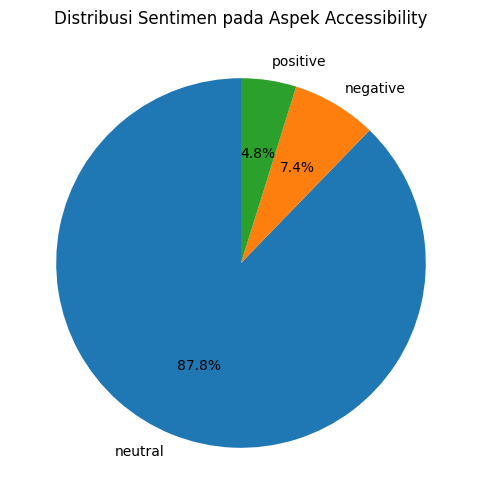

C:\Users\Nadya\AppData\Local\Temp\ipykernel_10892\1309188172.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='accessibility', data=df_cleaning, order=accessibility_counts.index, palette='pastel')


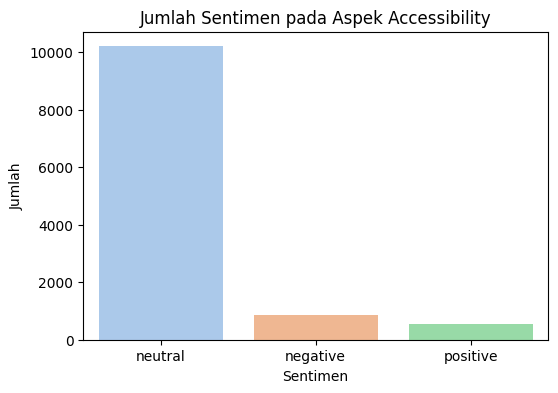

In [14]:
# Accessibility Chart
accessibility_counts = df_cleaning['accessibility'].value_counts()

# Pie Chart
accessibility_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6), startangle=90)
plt.title('Distribusi Sentimen pada Aspek Accessibility')
plt.ylabel('')
plt.show()

# Bar Chart
plt.figure(figsize=(6,4))
sns.countplot(x='accessibility', data=df_cleaning, order=accessibility_counts.index, palette='pastel')
plt.title('Jumlah Sentimen pada Aspek Accessibility')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

In [15]:
le = LabelEncoder()
df_accessibility['sentiment_encoded'] = le.fit_transform(df_accessibility['sentiment_accessibility'])
y = df_accessibility['sentiment_encoded']
X_text = df_accessibility['stemmed'].fillna('')

##### Splitting Data

In [16]:
X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size=0.3, random_state=42, stratify=y)

##### TF-IDF

In [17]:
# Hitung TF-IDF dari seluruh data (sebelum split)
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1,2), min_df=3)
X_train = vectorizer.fit_transform(X_text_train).toarray()
X_test = vectorizer.transform(X_text_test).toarray()

# Hitung total tf-idf per kata
vectorizer_all = TfidfVectorizer()
X_all_tfidf = vectorizer_all.fit_transform(df_accessibility['stemmed'].fillna('')).toarray()
terms_all = vectorizer_all.get_feature_names_out()
total_tfidf_per_term = np.sum(X_all_tfidf, axis=0)
top_indices = total_tfidf_per_term.argsort()[::-1][:10]
top_terms = [(terms_all[i], total_tfidf_per_term[i]) for i in top_indices]
print("Top 10 kata berdasarkan total skor TF-IDF (seluruh data):")
for term, score in top_terms:
    print(f"{term}: {score:.4f}")

Top 10 kata berdasarkan total skor TF-IDF (seluruh data):
tempat: 710.1004
bagus: 485.7244
nya: 307.0303
sangat: 293.2097
banyak: 290.4729
foto: 287.8236
jalan: 278.2027
pandang: 260.9432
sejuk: 260.2349
air: 259.7496


In [16]:
# y = df_accessibility['sentiment_accessibility'].values

In [18]:
tfidf_df = pd.DataFrame(X_train, columns=vectorizer.get_feature_names_out())
tfidf_df.head()

,10,10 menit,10 ribu,100,12,14,15,15 ribu,15000,20,...,yang buat,yang ingin,yang jual,yang kurang,yang senang,yang suka,yg,you,your,zaman
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.152345,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### SMOTE

In [19]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [20]:
print("\nUkuran data training setelah SMOTE:", X_train_resampled.shape)
print("Ukuran label training setelah SMOTE:", y_train_resampled.shape)


Ukuran data training setelah SMOTE: (21414, 3000)
Ukuran label training setelah SMOTE: (21414,)


##### Training Data

In [21]:
# training data
n_class = len(le.classes_)
model = MultinomialNB(class_prior=[1/n_class]*n_class)
model.fit(X_train_resampled, y_train_resampled)

MultinomialNB(class_prior=[0.3333333333333333, 0.3333333333333333,
                           0.3333333333333333])

##### Evaluasi Data (*Balanced Test Set*)

In [22]:
df_test = pd.DataFrame({'text': X_text_test, 'label': y_test})
df_test['label_name'] = le.inverse_transform(df_test['label'])

balanced_test = pd.concat([
    resample(df_test[df_test['label_name'] == label], 
             n_samples=100, 
             random_state=42)
    for label in le.classes_
])

X_test_balanced = vectorizer.transform(balanced_test['text']).toarray()
y_test_balanced = le.transform(balanced_test['label_name'])

In [23]:
y_pred = model.predict(X_test_balanced)
print("Evaluasi untuk Aspek Accessibility")
print(classification_report(y_test_balanced, y_pred, target_names=le.classes_))

Evaluasi untuk Aspek Accessibility
              precision    recall  f1-score   support

    negative       0.69      0.73      0.71       100
     neutral       0.62      0.79      0.69       100
    positive       0.71      0.47      0.57       100

    accuracy                           0.66       300
   macro avg       0.67      0.66      0.66       300
weighted avg       0.67      0.66      0.66       300



In [24]:
# Prediksi sentimen kalimat baru
new_sentence = "akses menuju tempat gampang"
new_sentence_tfidf = vectorizer.transform([new_sentence]).toarray()

# Pastikan jumlah fitur kalimat baru sama dengan jumlah fitur saat pelatihan
if new_sentence_tfidf.shape[1] == X_train.shape[1]:
    prediction = model.predict(new_sentence_tfidf)
    predicted_label = le.inverse_transform([prediction[0]])[0]
    print("Prediksi sentimen kalimat baru:", predicted_label)
else:
    print("\nError: Jumlah fitur kalimat baru tidak sesuai dengan jumlah fitur data training.")
    print("Periksa kembali proses vektorisasi.")

Prediksi sentimen kalimat baru: positive


In [25]:
model.predict_proba(new_sentence_tfidf)

array([[0.13174023, 0.02148225, 0.84677752]])

In [26]:
# save to pickle
with open('model_accessibility.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('vectorizer_accessibility.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
with open('label_encoder_accessibility.pkl', 'wb') as f:
    pickle.dump(le, f)

#### Facility

In [27]:
df_facility = df_cleaning[['stemmed', 'facility']].rename(columns={'facility': 'sentiment_facility'})
df_facility.head()

,stemmed,sentiment_facility
0,akses jalan waktu masih sulit jangkau jalan tu...,neutral
1,jalan benar buat syahduu tempat parkir lokasi ...,neutral
2,minggu 13 februari 2022 gas santai pakai motor...,negative
3,7 mei 2022touring bari mudikmntap jalan sunggu...,neutral
4,jalan touring motor bekas lewat trek saguling ...,neutral


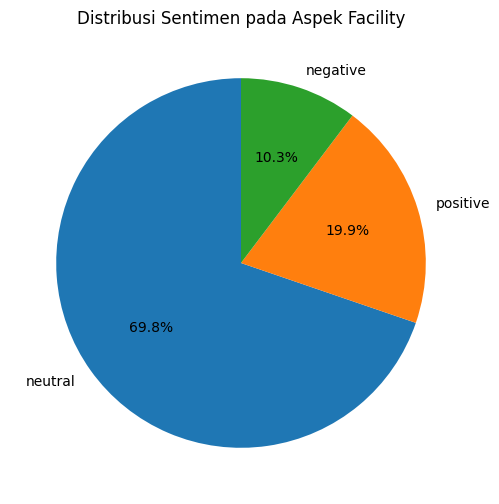

C:\Users\Nadya\AppData\Local\Temp\ipykernel_10892\1962932935.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='facility', data=df_cleaning, order=facility_counts.index, palette='pastel')


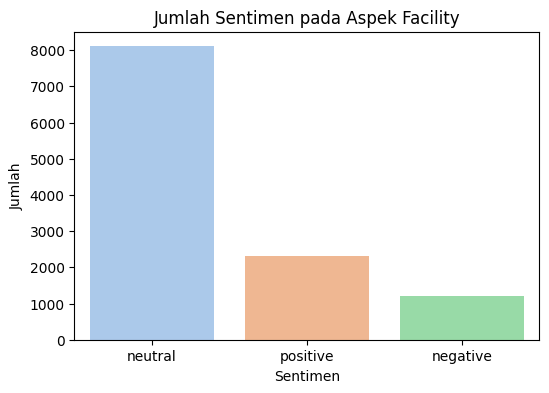

In [28]:
# Facility Chart
facility_counts = df_cleaning['facility'].value_counts()

# Pie Chart
facility_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6), startangle=90)
plt.title('Distribusi Sentimen pada Aspek Facility')
plt.ylabel('')
plt.show()

# Bar Chart
plt.figure(figsize=(6,4))
sns.countplot(x='facility', data=df_cleaning, order=facility_counts.index, palette='pastel')
plt.title('Jumlah Sentimen pada Aspek Facility')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

In [29]:
le = LabelEncoder()
df_facility['sentiment_encoded'] = le.fit_transform(df_facility['sentiment_facility'])
y = df_facility['sentiment_encoded']
X_text = df_facility['stemmed'].fillna('')

##### Split Data

In [30]:
# split data
X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size=0.3, random_state=42, stratify=y)

##### TF-IDF

In [31]:
# Hitung TF-IDF dari seluruh data (sebelum split)
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1,2), min_df=3)
X_train = vectorizer.fit_transform(X_text_train).toarray()
X_test = vectorizer.transform(X_text_test).toarray()

# Hitung total tf-idf per kata
vectorizer_all = TfidfVectorizer()
X_all_tfidf = vectorizer_all.fit_transform(df_facility['stemmed'].fillna('')).toarray()
terms_all = vectorizer_all.get_feature_names_out()
total_tfidf_per_term = np.sum(X_all_tfidf, axis=0)
top_indices = total_tfidf_per_term.argsort()[::-1][:10]
top_terms = [(terms_all[i], total_tfidf_per_term[i]) for i in top_indices]
print("Top 10 kata berdasarkan total skor TF-IDF (seluruh data):")
for term, score in top_terms:
    print(f"{term}: {score:.4f}")

Top 10 kata berdasarkan total skor TF-IDF (seluruh data):
tempat: 710.1004
bagus: 485.7244
nya: 307.0303
sangat: 293.2097
banyak: 290.4729
foto: 287.8236
jalan: 278.2027
pandang: 260.9432
sejuk: 260.2349
air: 259.7496


In [32]:
tfidf_df = pd.DataFrame(X_train, columns=vectorizer.get_feature_names_out())
tfidf_df.head()

,10,10 menit,10 ribu,100,10000,12,15,15 ribu,15000,16,...,yang cari,yang ingin,yang jual,yang kemah,yang kurang,yang sedia,yang suka,yang tidak,your,zaman
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### SMOTE

In [33]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [34]:
print("\nUkuran data training setelah SMOTE:", X_train_resampled.shape)
print("Ukuran label training setelah SMOTE:", y_train_resampled.shape)


Ukuran data training setelah SMOTE: (17019, 3000)
Ukuran label training setelah SMOTE: (17019,)


##### Training Data

In [35]:
# training data
n_class = len(le.classes_)
model = MultinomialNB(class_prior=[1/n_class]*n_class)
model.fit(X_train_resampled, y_train_resampled)

MultinomialNB(class_prior=[0.3333333333333333, 0.3333333333333333,
                           0.3333333333333333])

##### Evaluasi Data (*Balanced Test Set*)

In [36]:
df_test = pd.DataFrame({'text': X_text_test, 'label': y_test})
df_test['label_name'] = le.inverse_transform(df_test['label'])

balanced_test = pd.concat([
    resample(df_test[df_test['label_name'] == label], 
             n_samples=100, 
             random_state=42)
    for label in le.classes_
])

X_test_balanced = vectorizer.transform(balanced_test['text']).toarray()
y_test_balanced = le.transform(balanced_test['label_name'])

In [37]:
y_pred = model.predict(X_test_balanced)
print("Evaluasi untuk Aspek Facility")
print(classification_report(y_test_balanced, y_pred, target_names=le.classes_))

Evaluasi untuk Aspek Facility
              precision    recall  f1-score   support

    negative       0.75      0.60      0.67       100
     neutral       0.62      0.65      0.64       100
    positive       0.54      0.63      0.58       100

    accuracy                           0.63       300
   macro avg       0.64      0.63      0.63       300
weighted avg       0.64      0.63      0.63       300



In [38]:
# Prediksi sentimen kalimat baru
new_sentence = "fasilitasnya jelek"
new_sentence_tfidf = vectorizer.transform([new_sentence]).toarray()
print("Ukuran fitur kalimat baru setelah transformasi:", new_sentence_tfidf.shape[1])

# Pastikan jumlah fitur kalimat baru sama dengan jumlah fitur saat pelatihan
if new_sentence_tfidf.shape[1] == X_train.shape[1]:
    prediction = model.predict(new_sentence_tfidf)
    predicted_label = le.inverse_transform([prediction[0]])[0]
    print("\nPrediksi sentimen kalimat baru:", predicted_label)
else:
    print("\nError: Jumlah fitur kalimat baru tidak sesuai dengan jumlah fitur data training.")
    print("Periksa kembali proses vektorisasi.")

Ukuran fitur kalimat baru setelah transformasi: 3000

Prediksi sentimen kalimat baru: negative


In [39]:
model.predict_proba(new_sentence_tfidf)

array([[0.43465669, 0.43237344, 0.13296987]])

In [40]:
# save to pickle
with open('model_facility.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('vectorizer_facility.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
with open('label_encoder_facility.pkl', 'wb') as f:
    pickle.dump(le, f)

#### Activity

In [41]:
df_activity = df_cleaning[['stemmed', 'activity']].rename(columns={'activity': 'sentiment_activity'})
df_activity.head()

,stemmed,sentiment_activity
0,akses jalan waktu masih sulit jangkau jalan tu...,neutral
1,jalan benar buat syahduu tempat parkir lokasi ...,positive
2,minggu 13 februari 2022 gas santai pakai motor...,positive
3,7 mei 2022touring bari mudikmntap jalan sunggu...,positive
4,jalan touring motor bekas lewat trek saguling ...,positive


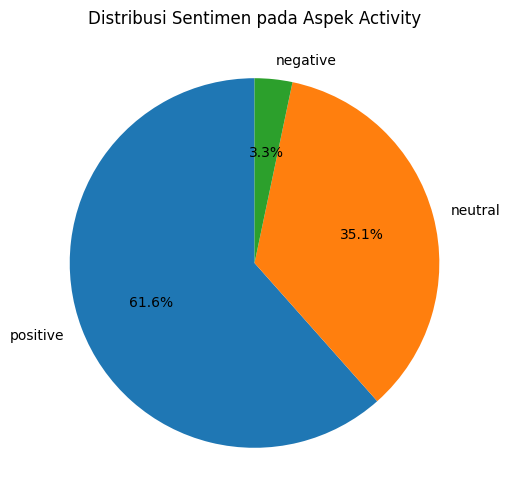

C:\Users\Nadya\AppData\Local\Temp\ipykernel_10892\3955276338.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='activity', data=df_cleaning, order=activity_counts.index, palette='pastel')


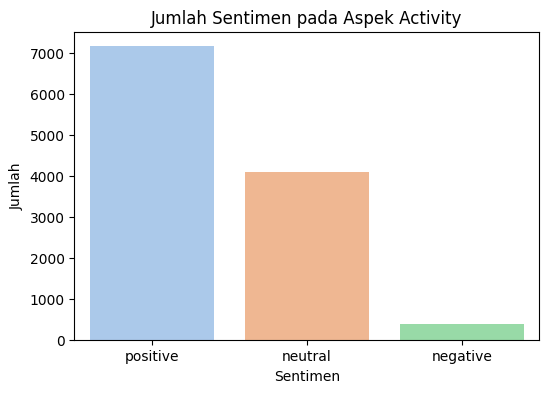

In [42]:
# Activity Chart
activity_counts = df_cleaning['activity'].value_counts()

# Pie Chart
activity_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6), startangle=90)
plt.title('Distribusi Sentimen pada Aspek Activity')
plt.ylabel('')
plt.show()

# Bar Chart
plt.figure(figsize=(6,4))
sns.countplot(x='activity', data=df_cleaning, order=activity_counts.index, palette='pastel')
plt.title('Jumlah Sentimen pada Aspek Activity')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

In [43]:
le = LabelEncoder()
df_activity['sentiment_encoded'] = le.fit_transform(df_activity['sentiment_activity'])
y = df_activity['sentiment_encoded']
X_text = df_activity['stemmed'].fillna('')

##### Split Data

In [44]:
X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size=0.3, random_state=42, stratify=y)

##### TF-IDF

In [45]:
# Hitung TF-IDF dari seluruh data (sebelum split)
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1,2), min_df=3)
X_train = vectorizer.fit_transform(X_text_train).toarray()
X_test = vectorizer.transform(X_text_test).toarray()

# Hitung total tf-idf per kata
vectorizer_all = TfidfVectorizer()
X_all_tfidf = vectorizer_all.fit_transform(df_activity['stemmed'].fillna('')).toarray()
terms_all = vectorizer_all.get_feature_names_out()
total_tfidf_per_term = np.sum(X_all_tfidf, axis=0)
top_indices = total_tfidf_per_term.argsort()[::-1][:10]
top_terms = [(terms_all[i], total_tfidf_per_term[i]) for i in top_indices]
print("Top 10 kata berdasarkan total skor TF-IDF (seluruh data):")
for term, score in top_terms:
    print(f"{term}: {score:.4f}")

Top 10 kata berdasarkan total skor TF-IDF (seluruh data):
tempat: 710.1004
bagus: 485.7244
nya: 307.0303
sangat: 293.2097
banyak: 290.4729
foto: 287.8236
jalan: 278.2027
pandang: 260.9432
sejuk: 260.2349
air: 259.7496


In [46]:
tfidf_df = pd.DataFrame(X_train, columns=vectorizer.get_feature_names_out())
tfidf_df.head()

,10,10 menit,10 ribu,100,11,12,12 ribu,14,15,15 menit,...,yang cukup,yang ingin,yang jual,yang kemah,yang kurang,yang suka,yang tidak,you,your,zaman
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.109102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### SMOTE

In [47]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [48]:
print("\nUkuran data training setelah SMOTE:", X_train_resampled.shape)
print("Ukuran label training setelah SMOTE:", y_train_resampled.shape)


Ukuran data training setelah SMOTE: (15021, 3000)
Ukuran label training setelah SMOTE: (15021,)


##### Training Data

In [49]:
# training data
n_class = len(le.classes_)
model = MultinomialNB(class_prior=[1/n_class]*n_class)
model.fit(X_train_resampled, y_train_resampled)

MultinomialNB(class_prior=[0.3333333333333333, 0.3333333333333333,
                           0.3333333333333333])

##### Evaluasi Data (*Balanced Test Set*)

In [50]:
df_test = pd.DataFrame({'text': X_text_test, 'label': y_test})
df_test['label_name'] = le.inverse_transform(df_test['label'])

balanced_test = pd.concat([
    resample(df_test[df_test['label_name'] == label], 
             n_samples=100, 
             random_state=42)
    for label in le.classes_
])

X_test_balanced = vectorizer.transform(balanced_test['text']).toarray()
y_test_balanced = le.transform(balanced_test['label_name'])

In [51]:
y_pred = model.predict(X_test_balanced)
print("Evaluasi untuk Aspek Activity")
print(classification_report(y_test_balanced, y_pred, target_names=le.classes_))

Evaluasi untuk Aspek Activity
              precision    recall  f1-score   support

    negative       0.74      0.75      0.75       100
     neutral       0.55      0.52      0.53       100
    positive       0.57      0.59      0.58       100

    accuracy                           0.62       300
   macro avg       0.62      0.62      0.62       300
weighted avg       0.62      0.62      0.62       300



In [52]:
# Prediksi sentimen kalimat baru
new_sentence = "aktivitas yang bisa dilakukan di tempat ini cenderung terbatas"
new_sentence_tfidf = vectorizer.transform([new_sentence]).toarray()
print("Ukuran fitur kalimat baru setelah transformasi:", new_sentence_tfidf.shape[1])

# Pastikan jumlah fitur kalimat baru sama dengan jumlah fitur saat pelatihan
if new_sentence_tfidf.shape[1] == X_train.shape[1]:
    prediction = model.predict(new_sentence_tfidf)
    predicted_label = le.inverse_transform([prediction[0]])[0]
    print("\nPrediksi sentimen kalimat baru:", predicted_label)
else:
    print("\nError: Jumlah fitur kalimat baru tidak sesuai dengan jumlah fitur data training.")
    print("Periksa kembali proses vektorisasi.")

Ukuran fitur kalimat baru setelah transformasi: 3000

Prediksi sentimen kalimat baru: negative


In [53]:
model.predict_proba(new_sentence_tfidf)

array([[0.43078182, 0.26252163, 0.30669655]])

In [54]:
# save to pickle
with open('model_activity.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('vectorizer_activity.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
with open('label_encoder_activity.pkl', 'wb') as f:
    pickle.dump(le, f)

### Simpan ke Pickle

In [57]:
def predict_sentiment(text, aspect_name):
    # Load model, vectorizer, dan label encoder
    with open(f'model_{aspect_name}.pkl', 'rb') as f:
        model = pickle.load(f)
    with open(f'vectorizer_{aspect_name}.pkl', 'rb') as f:
        vectorizer = pickle.load(f)
    with open(f'label_encoder_{aspect_name}.pkl', 'rb') as f:
        le = pickle.load(f)

    # Transformasi teks input
    X_input = vectorizer.transform([text]).toarray()

    # Prediksi probabilitas
    y_proba = model.predict_proba(X_input)[0]
    y_pred = model.predict(X_input)[0]

    # Ambil label prediksi dan confidence-nya
    label = le.inverse_transform([y_pred])[0]
    confidence = round(y_proba[y_pred] * 100, 2)

    return label, confidence

In [59]:
kalimat = "akses menuju tempat wisatanya gampang dituju dan fasilitas di dalamnya juga bagus, tapi aktivitas yg bisa dilakukan terbatas"

for aspect in ['accessibility', 'facility', 'activity']:
    label, confidence = predict_sentiment(kalimat, aspect)
    print(f"Aspek {aspect.capitalize()}: {label} ({confidence}%)")

Aspek Accessibility: positive (66.17%)
Aspek Facility: positive (41.3%)
Aspek Activity: negative (33.82%)


TF (term frequency) = mengukur seberapa sering sebuah kata/token muncul di dokoumen.

TF_t,d = jumlah kata *t* di dokumen *d* / jumlah total kata di dokumen *d*

IDF (inverse document frequency) = mengukur seberapa penting kata/token tersebut terhadap keseluruhan dokumen, di mana semakin jarang muncul berarti nilai IDF nya semakin tinggi.

IDF_t = log (N + 1 / df_t + 1) + 1

N = total dokumen

df_t = banyak dokumen yang mengandung kata/token *t*

TF-IDF = TF_t,d * IDF_t

In [16]:
df_tfidf = df_cleaning['stemmed']

In [17]:
df_tfidf

0        akses jalan waktu masih sulit jangkau jalan tu...
1        jalan benar buat syahduu tempat parkir lokasi ...
2        minggu 13 februari 2022 gas santai pakai motor...
3        7 mei 2022touring bari mudikmntap jalan sunggu...
4        jalan touring motor bekas lewat jalur saguling...
                               ...                        
11615    coba sarap off-road pakai land rover makananya...
11616    pngnnya tempat petik strawberry lagi panen jad...
11617    ksini main dan lihat lihat suasana emg enak se...
11618          luar biasa mantap makan prasmanan nya murah
11619                      tempat suasana sejuk bangeeettt
Name: stemmed, Length: 11620, dtype: object

### TF-IDF Using Library

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

df_tfidf = df_cleaning.copy()
df_tfidf['stemmed'] = df_tfidf['stemmed'].fillna('')

# Proses TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_tfidf['stemmed']).toarray()

In [20]:
tfidf_df = pd.DataFrame(X, columns=vectorizer.get_feature_names_out())
tfidf_df.head()

,00,000,000orang,0030,03,0430,0445,05pagiam,0600,060122,...,zip,zmn,zona,zone,zonk,zoo,zoodoa,zoonya,zuhur,zzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
print("Jumlah dokumen:", X.shape[0])
print("Jumlah fitur (kata unik):", X.shape[1])

Jumlah dokumen: 11620
Jumlah fitur (kata unik): 20358


In [22]:
total_tfidf_per_term = np.sum(X, axis=0)
terms = vectorizer.get_feature_names_out()

# show the 10 words most appear
top_indices = total_tfidf_per_term.argsort()[::-1][:10]
top_terms = [(terms[i], total_tfidf_per_term[i]) for i in top_indices]

print("Top 10 kata berdasarkan total skor TF-IDF:")
for term, score in top_terms:
    print(f"{term}: {score:.4f}")

Top 10 kata berdasarkan total skor TF-IDF:
tempat: 695.8170
bagus: 470.1343
nya: 350.1149
sangat: 289.9026
banyak: 287.5653
foto: 281.4429
jalan: 276.0737
pandang: 256.7598
indah: 256.6684
air: 255.4513


# Manual Version

### TF-IDF Manual

In [45]:
def compute_tfidf_manual(texts):
    # 1. Tokenisasi
    tokenized_docs = [text.lower().split() for text in texts]

    # 2. Buat vocabulary unik
    vocab = sorted(set(word for doc in tokenized_docs for word in doc))

    # 3. Hitung TF untuk setiap dokumen
    tf = []
    for doc in tokenized_docs:
        word_count = Counter(doc)
        doc_len = len(doc)
        tf.append([word_count.get(word, 0) / doc_len if doc_len > 0 else 0 for word in vocab])

    # 4. Hitung DF dan IDF (pakai smoothing seperti sklearn)
    N = len(tokenized_docs)
    df = [sum(1 for doc in tokenized_docs if word in doc) for word in vocab]
    idf = [math.log((1 + N) / (1 + df_i)) + 1 for df_i in df]

    # 5. Hitung TF-IDF
    tfidf = []
    for tf_row in tf:
        tfidf.append([tf_val * idf_val for tf_val, idf_val in zip(tf_row, idf)])

    # 6. Normalisasi L2 tiap baris
    tfidf_array = np.array(tfidf)
    norms = np.linalg.norm(tfidf_array, axis=1, keepdims=True)
    norms[norms == 0] = 1e-10  # untuk menghindari pembagian dengan nol
    tfidf_normalized = tfidf_array / norms

    return pd.DataFrame(tfidf_normalized, columns=vocab)

In [47]:
df_combined['stemmed'] = df_combined['stemmed'].fillna('')
tfidf_df_manual = compute_tfidf_manual(df_combined['stemmed'])
tfidf_df_manual.head()

,0,00,000,000orang,0030,03,0430,0445,05pagiam,0600,...,zip,zmn,zona,zone,zonk,zoo,zoodoa,zoonya,zuhur,zzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# Gunakan dataframe yang sama
texts = df_combined['stemmed'].fillna('').tolist()

# Hasil TF-IDF dari library
vectorizer = TfidfVectorizer()
X_lib = vectorizer.fit_transform(texts).toarray()
df_lib = pd.DataFrame(X_lib, columns=vectorizer.get_feature_names_out())

# Hasil TF-IDF manual
df_manual = compute_tfidf_manual(texts)

# Samakan kolom untuk dibandingkan (interseksi kata-kata saja)
common_cols = sorted(set(df_lib.columns).intersection(set(df_manual.columns)))
lib_common = df_lib[common_cols]
manual_common = df_manual[common_cols]

# Bandingkan selisih absolut antar semua nilai
diff = np.abs(lib_common.values - manual_common.values)

# Tampilkan statistik perbandingan
print("Rata-rata selisih TF-IDF:", np.mean(diff))
print("Maksimum selisih TF-IDF:", np.max(diff))

# Cek apakah seluruh nilai hampir sama (toleransi 1e-4)
if np.allclose(lib_common.values, manual_common.values, atol=1e-4):
    print("✅ Hasil manual dan library hampir identik (perbedaan sangat kecil)")
else:
    print("⚠️ Ada perbedaan signifikan antara TF-IDF manual dan library")

Rata-rata selisih TF-IDF: 6.410822358695364e-07
Maksimum selisih TF-IDF: 0.7282629577462365
⚠️ Ada perbedaan signifikan antara TF-IDF manual dan library


## Split Data

In [23]:
y = df_combined['stemmed'].values

In [24]:
n_total = len(X)
indices = np.arange(n_total)
np.random.seed(42)
np.random.shuffle(indices)

# Misal: 80% training, 20% testing
split_idx = int(0.8 * n_total)
train_idx = indices[:split_idx]
test_idx = indices[split_idx:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

## SMOTE

### Menyeimbangkan *accessibility*

In [24]:
y = df_combined['accessibility']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

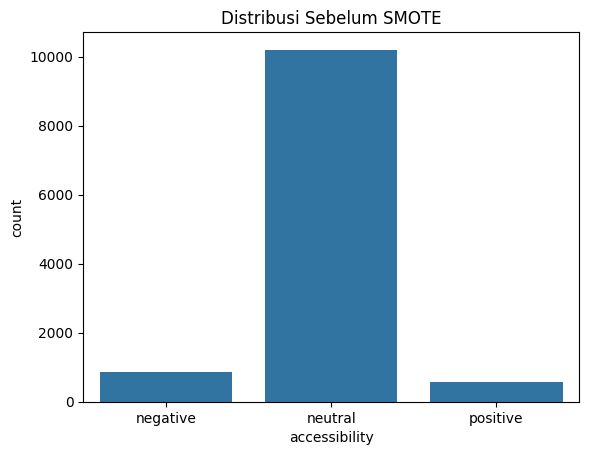

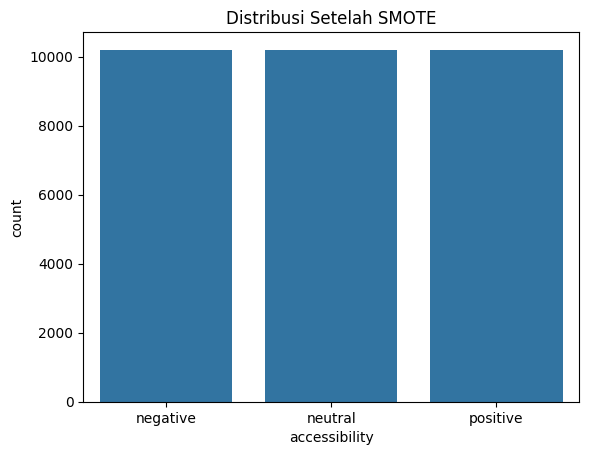

In [25]:
# visualisasi

sns.countplot(x=y)
plt.title("Distribusi Sebelum SMOTE")
plt.show()

# Sesudah SMOTE
sns.countplot(x=y_resampled)
plt.title("Distribusi Setelah SMOTE")
plt.show()

In [32]:
from tqdm import tqdm

n_original = len(X)
new_samples = X_resampled[n_original:]

identical_count = 0
for sample in tqdm(new_samples, desc="Mengecek kemiripan"):
    if any(np.allclose(sample, x, atol=1e-10) for x in X):
        identical_count += 1

print("Jumlah data sintetis:", len(new_samples))
print("Jumlah yang identik 100%:", identical_count)

Mengecek kemiripan: 100%|████████████████████████████████████████████████████████| 9839/9839 [7:09:59<00:00,  2.62s/it]

Jumlah data sintetis: 9839
Jumlah yang identik 100%: 34


### Menyeimbangkan *facility*

In [28]:
y = df_combined['facility']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

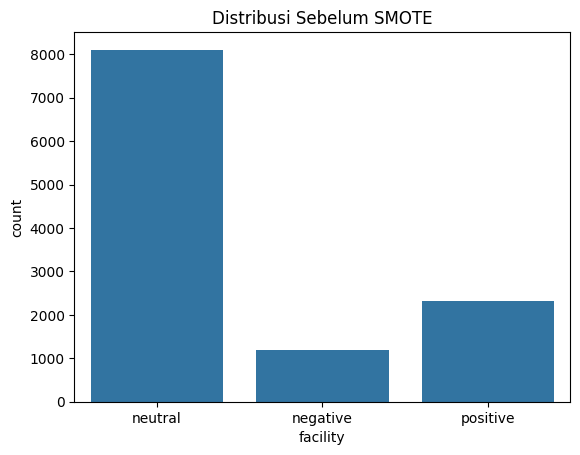

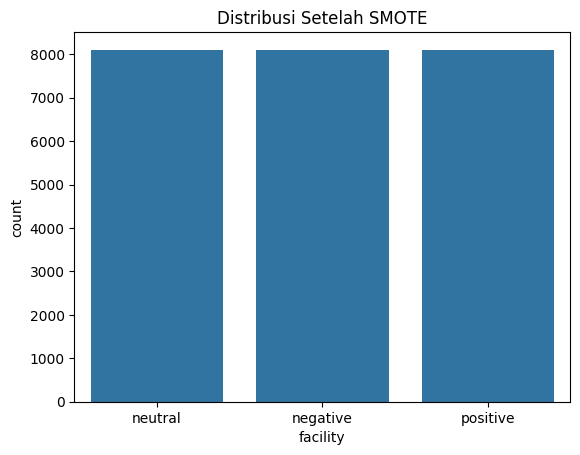

In [29]:
# visualisasi

sns.countplot(x=y)
plt.title("Distribusi Sebelum SMOTE")
plt.show()

# Sesudah SMOTE
sns.countplot(x=y_resampled)
plt.title("Distribusi Setelah SMOTE")
plt.show()

### Menyeimbangkan *activity*

In [30]:
y = df_combined['activity']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

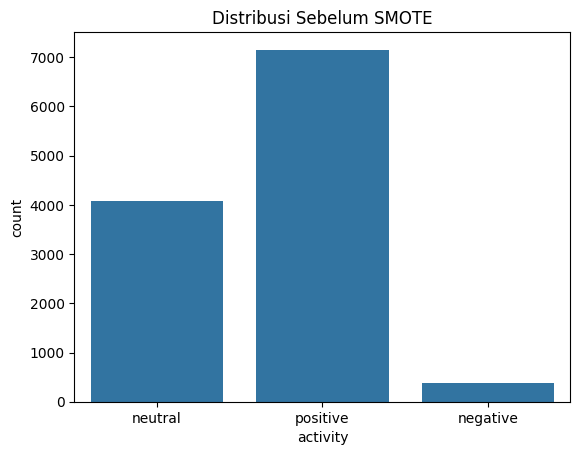

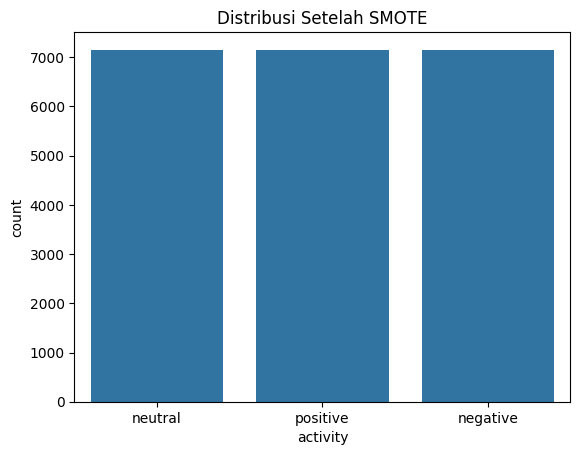

In [31]:
# visualisasi

sns.countplot(x=y)
plt.title("Distribusi Sebelum SMOTE")
plt.show()

# Sesudah SMOTE
sns.countplot(x=y_resampled)
plt.title("Distribusi Setelah SMOTE")
plt.show()

## Naive Bayes

In [32]:
def train_naive_bayes(X, y):
    y = np.array(y)  # pastikan y adalah numpy array
    classes = np.unique(y)
    model = {}

    for c in classes:
        X_c = X[y == c]  # X_c: semua data fitur untuk kelas c
        total_wc = X_c.sum(axis=0) + 1e-6  # Laplace smoothing (tambahkan epsilon kecil)
        total_words = total_wc.sum()
        prob_wc = total_wc / total_words
        model[c] = {
            'prior': len(X_c) / len(X),
            'likelihood': prob_wc
        }
    return model

In [33]:
def predict_naive_bayes(X, model):
    classes = list(model.keys())
    predictions = []

    for x in X:
        probs = {}
        for c in classes:
            # Hindari log(0)
            likelihood = model[c]['likelihood']
            likelihood = np.where(likelihood == 0, 1e-6, likelihood)

            log_prior = np.log(model[c]['prior'])
            log_likelihood = np.sum(np.log(likelihood) * x)
            probs[c] = log_prior + log_likelihood
        predictions.append(max(probs, key=probs.get))

    return np.array(predictions)

### Training Data

In [43]:
print(set(type(label) for label in y_train))  # cek tipe data dalam y_train

{<class 'numpy.str_'>}


In [40]:
import numpy as np
from tqdm import tqdm

# Fungsi training Naive Bayes
def train_naive_bayes(X, y):
    # Konversi semua label ke string agar bisa diproses dengan aman
    y = np.array([str(label) for label in y])
    classes = np.unique(y)
    n_features = X.shape[1]
    model = {}

    for c in classes:
        X_c = X[y == c]
        total_wc = X_c.sum(axis=0) + 1e-6  # Laplace smoothing
        total_words = total_wc.sum()
        prob_wc = total_wc / total_words
        model[c] = {
            'prior': len(X_c) / len(X),
            'likelihood': prob_wc
        }
    return model

# Fungsi prediksi Naive Bayes
def predict_naive_bayes(X, model):
    classes = list(model.keys())
    predictions = []

    for x in tqdm(X, desc="Predicting"):
        probs = {}
        for c in classes:
            log_prior = np.log(model[c]['prior'])
            log_likelihood = np.sum(np.log(model[c]['likelihood']) * x)
            probs[c] = log_prior + log_likelihood
        predictions.append(max(probs, key=probs.get))
    return np.array(predictions)

In [41]:
y_train = np.array([str(label) for label in y_train])

In [42]:
model = train_naive_bayes(X_train, y_train)
y_pred = predict_naive_bayes(X_test, model)

Predicting: 100%|████████████████████████████████████████████████████████████████| 2324/2324 [1:37:38<00:00,  2.52s/it]


In [28]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [39]:
y_train

array(['indaaaaaahhhh',
       'suka sekali tempat indah bersih tempat foto2nya banyak romantis tiket sahabat tahan tingkat biar unjung makin banyak',
       'asik sih cari udara sejuk wajib coba', ..., 'tempat mantaph',
       'cukup baik',
       'syaaahhdu naik kuda 50 sya tawar 30 wh jlnnya di pendek hahaaa'],
      dtype=object)

In [30]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Evaluasi Model

In [55]:
y_access = df_cleaning['accessibility']
y_facility = df_cleaning['facility']
y_activity = df_cleaning['activity']
y_rating = df_cleaning['rating']

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_acc_train, y_acc_test = train_test_split(X, y_access, test_size=0.2, random_state=42)
_, _, y_fac_train, y_fac_test = train_test_split(X, y_facility, test_size=0.2, random_state=42)
_, _, y_act_train, y_act_test = train_test_split(X, y_activity, test_size=0.2, random_state=42)
_, _, y_rat_train, y_rat_test = train_test_split(X, y_rating, test_size=0.2, random_state=42)

In [57]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

In [58]:
# buat modul untuk setiap aspek
nb_acc = MultinomialNB()
nb_fac = MultinomialNB()
nb_act = MultinomialNB()
nb_rat = MultinomialNB()

nb_acc.fit(X_train, y_acc_train)
nb_fac.fit(X_train, y_fac_train)
nb_act.fit(X_train, y_act_train)
nb_rat.fit(X_train, y_rat_train)

MultinomialNB()